# Solving mixed integer programs with Julia/JuMP

<i>Copyright 2016, Pedro Belin Castellucci,

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.</i>


In this Notebook, we will explore some basics of the JuMP modeling language. Although it is a modeling language, it enables the usage of different solvers. By ways of an example, we will use [Clp](https://projects.coin-or.org/Clp)
-- a complete list of supported solvers and JuMP documentation can be found at this [link](https://jump.readthedocs.io/en/latest/). Also, JuMP support linear programming, mixed-integer programming, second-order conic programming, semidefinite programming, and nonlinear programming, but we will focus on linear and integer programming here.

The first step is to install JuMP.

In [1]:
Pkg.add("JuMP")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of JuMP
INFO: Use `Pkg.update()` to get the latest versions of your packages


We can also install Clp in the same way.

In [14]:
Pkg.add("Clp")

INFO: Cloning cache of Cbc from https://github.com/JuliaOpt/Cbc.jl.git
INFO: Cloning cache of Clp from https://github.com/JuliaOpt/Clp.jl.git
INFO: Installing Cbc v0.3.0
INFO: Installing Clp v0.3.0
INFO: Building Cbc
INFO: Attempting to Create directory /home/pedro/.julia/v0.5/Cbc/deps/downloads
INFO: Downloading file http://www.coin-or.org/download/source/Cbc/Cbc-2.9.8.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   265  100   265    0     0    314      0 --:--:-- --:--:-- --:--:--   313
100 13.0M  100 13.0M    0     0   233k      0  0:00:57  0:00:57 --:--:--  226k
INFO: Done downloading file http://www.coin-or.org/download/source/Cbc/Cbc-2.9.8.tgz
INFO: Attempting to Create directory /home/pedro/.julia/v0.5/Cbc/deps/src
INFO: Attempting to Create directory /home/pedro/.julia/v0.5/Cbc/deps
INFO: Directory /home/pedro/.julia/v0.5/Cbc/deps already created
INFO: Changin

checking build system type... x86_64-unknown-linux-gnu
checking whether we want to compile in debug mode... no
checking for gcc... gcc
checking for C compiler default output file name... a.out
checking whether the C compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ANSI C... none needed
configure: C compiler options are: -O3 -pipe -DNDEBUG -pedantic-errors -Wimplicit -Wparentheses -Wsequence-point -Wreturn-type -Wcast-qual -Wall -Wno-unknown-pragmas -Wno-long-long  
checking for g++... g++
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking whether C++ compiler g++ works... yes
configure: C++ compiler options are: -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith

configure: WARNING: Failed to find a Fortran compiler!


checking for egrep... grep -E
checking whether ln -s works... yes
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking for style of include used by make... GNU
checking dependency style of gcc... gcc3
checking dependency style of g++... gcc3
checking whether to enable maintainer-specific portions of Makefiles... no
checking host system type... x86_64-unknown-linux-gnu
checking for a sed that does not truncate output... /bin/sed
checking for ld used by gcc... /usr/bin/ld
checking if the linker (/usr/bin/ld) is GNU ld... yes
checking for /usr/bin/ld option to reload object files... -r
checking for BSD-compatible nm... 

./configure: line 5844: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


/usr/bin/nm -B
checking how to recognise dependent libraries... pass_all
checking how to run the C preprocessor... gcc -E
checking for ANSI C header files... no
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes
checking for inttypes.h... yes
checking for stdint.h... yes
checking for unistd.h... yes
checking dlfcn.h usability... yes
checking dlfcn.h presence... yes
checking for dlfcn.h... yes
checking how to run the C++ preprocessor... g++ -E
checking the maximum length of command line arguments... 32768
checking command to parse /usr/bin/nm -B output from gcc object... ok
checking for objdir... .libs
checking for ar... ar
checking for ranlib... ranlib
checking for strip... strip
checking if gcc supports -fno-rtti -fno-exceptions... no
checking for gcc option to produce PIC... -fPIC
checking if gcc PIC flag -fPIC works... yes
checking if gcc static flag -stat

./configure: line 16395: unavailable: command not found


configure: Build is "x86_64-unknown-linux-gnu".
checking if library version is set... no
checking whether source of project ASL is available and should be compiled... no, source file ./ThirdParty/ASL/solvers/asl.h not available
checking whether source of project Blas is available and should be compiled... no, --without-blas has been specified
checking whether source of project Lapack is available and should be compiled... no, --without-lapack has been specified
checking whether source of project Glpk is available and should be compiled... no, source file ./ThirdParty/Glpk/glpk/src/glpk.h not available
checking whether source of project Metis is available and should be compiled... no, source file ./ThirdParty/Metis/metis-4.0/Lib/balance.c not available
checking whether source of project Mumps is available and should be compiled... no, source file ./ThirdParty/Mumps/MUMPS/src/dmumps_part1.F not available
checking whether source of project Sample is available and should be compiled... yes

./configure: line 2236: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


configure: creating ./config.status
config.status: creating Makefile
config.status: creating coindatasample.pc
config.status: creating coindatasample-uninstalled.pc
configure: In case of trouble, first consult the troubleshooting page at https://projects.coin-or.org/BuildTools/wiki/user-troubleshooting
configure: Configuration of DataSample successful
configure: configuring in Data/miplib3
configure: running /bin/bash './configure' --prefix=/home/pedro/.julia/v0.5/Cbc/deps/usr  '--prefix=/home/pedro/.julia/v0.5/Cbc/deps/usr' '--without-blas' '--without-lapack' '--enable-cbc-parallel' --cache-file=/dev/null --srcdir=.
checking for svnversion... no
checking for egrep... grep -E
checking whether ln -s works... yes
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether to enable maintainer-specific portions of Makefiles... no
c

./configure: line 2308: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


a.out
checking whether the C compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ANSI C... none needed
checking dependency style of gcc... gcc3
checking how to run the C preprocessor... gcc -E
checking for ANSI C header files... yes
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes
checking for inttypes.h... yes
checking for stdint.h... yes
checking for unistd.h... yes
checking zlib.h usability... no
checking zlib.h presence... no
checking for zlib.h... no
checking whether this is a VPATH configuration... no
checking build system type... x86_64-unknown-linux-gnu
checking which command should be used to link input files... ln -s
configure

configure: WARNING: Failed to find a Fortran compiler!


checking for egrep... grep -E
checking whether ln -s works... yes
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking for style of include used by make... GNU
checking dependency style of gcc... gcc3
checking dependency style of g++... gcc3
checking whether to enable maintainer-specific portions of Makefiles... no
configure: Using libtool script in directory ..


./configure: line 6877: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


checking if library version is set... 13:13:10
checking cmath usability... yes
checking cmath presence... yes
checking for cmath... yes
checking cfloat usability... yes
checking cfloat presence... yes
checking for cfloat... yes
checking cieeefp usability... no
checking cieeefp presence... no
checking for cieeefp... no
checking ieeefp.h usability... no
checking ieeefp.h presence... no
checking for ieeefp.h... no
checking whether isfinite is declared... no
checking whether finite is declared... yes
checking for cmath... (cached) yes
checking for cfloat... (cached) yes
checking for cieeefp... (cached) no
checking for ieeefp.h... (cached) no
checking whether isnan is declared... yes
checking cinttypes usability... no
checking cinttypes presence... no
checking for cinttypes... no
checking inttypes.h usability... yes
checking inttypes.h presence... yes
checking for inttypes.h... yes
checking cstdint usability... no
checking cstdint presence... no
checking for cstdint... no
checking stdint.h 

./configure: line 5268: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


checking if library version is set... 13:8:12
checking for pkg-config... pkg-config
checking pkg-config is at least version 0.16.0... yes
checking for COIN-OR package CoinUtils... yes: 2.10.13 
checking for COIN-OR package Glpk... not given: No package 'coinglpk' found
checking for COIN-OR package SoPlex... not given: No package 'coinsoplex' found
checking for COIN-OR package Sample... yes: 1.2.10 
checking for COIN-OR package Netlib... not given: No package 'coindatanetlib' found
checking if user provides library for Cplex... no
checking if user provides library for Mosek... no
checking if user provides library for Xpress... no
checking if user provides library for Gurobi... no
configure: configuring doxygen documentation options
checking for doxygen... no
checking for latex... no
checking for dot... NO
checking for doxygen doc'n for CoinUtils ... ../CoinUtils/doxydoc (tag)
checking cmath usability... 

configure: WARNING: No solver available, examples will not work.


yes
checking cmath presence... yes
checking for cmath... yes
checking cfloat usability... yes
checking cfloat presence... yes
checking for cfloat... yes
checking cieeefp usability... no
checking cieeefp presence... no
checking for cieeefp... no
checking ieeefp.h usability... no
checking ieeefp.h presence... no
checking for ieeefp.h... no
checking which command should be used to link input files... ln -s
configure: creating ./config.status
config.status: creating Makefile
config.status: creating examples/Makefile
config.status: creating src/Osi/Makefile
config.status: creating src/OsiCpx/Makefile
config.status: creating src/OsiGlpk/Makefile
config.status: creating src/OsiMsk/Makefile
config.status: creating src/OsiXpr/Makefile
config.status: creating src/OsiGrb/Makefile
config.status: creating src/OsiSpx/Makefile
config.status: creating src/OsiCommonTest/Makefile
config.status: creating test/Makefile
config.status: creating osi.pc
config.status: creating osi-uninstalled.pc
config.status

./configure: line 5300: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


checking if library version is set... 14:10:13
checking for pkg-config... pkg-config
checking pkg-config is at least version 0.16.0... yes
checking for COIN-OR package CoinUtils... yes: 2.10.13 
checking for COIN-OR package Osi... yes: 0.107.8 
checking for COIN-OR package OsiTests... yes: 0.107.8 
checking for COIN-OR package Sample... yes: 1.2.10 
checking for COIN-OR package Netlib... not given: No package 'coindatanetlib' found
checking if user provides library for AMD... no
checking if user provides library for CHOLMOD... no
checking for COIN-OR package Glpk... not given: No package 'coinglpk' found
checking for COIN-OR package Mumps... not given: No package 'coinmumps' found
checking for COIN-OR package ASL... not given: No package 'coinasl' found
checking cmath usability... yes
checking cmath presence... yes
checking for cmath... yes
checking cfloat usability... yes
checking cfloat presence... yes
checking for cfloat... yes
checking cieeefp usability... no
checking cieeefp prese

./configure: line 5270: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


checking if library version is set... 10:9:9
checking for pkg-config... pkg-config
checking pkg-config is at least version 0.16.0... yes
checking for COIN-OR package CoinUtils... yes: 2.10.13 
checking for COIN-OR package Osi... yes: 0.107.8 
checking for COIN-OR package Sample... yes: 1.2.10 
checking for COIN-OR package OsiClp... yes: 1.16.10 
checking for COIN-OR package OsiCpx... not given: No package 'osi-cplex' found
checking for COIN-OR package OsiGlpk... not given: No package 'osi-glpk' found
checking for COIN-OR package OsiMsk... not given: No package 'osi-mosek' found
checking for COIN-OR package OsiXpr... not given: No package 'osi-xpress' found
checking for COIN-OR package OsiVol... not given: No package 'osi-vol' found
checking for COIN-OR package OsiDyLP... not given: No package 'osi-dylp' found
checking cmath usability... yes
checking cmath presence... yes
checking for cmath... yes
checking cfloat usability... yes
checking cfloat presence... yes
checking for cfloat... ye

./configure: line 5304: cd: /home/pedro/.julia/v0.5/Cbc/deps/usr: No such file or directory


checking if library version is set... 12:8:9
checking for pkg-config... pkg-config
checking pkg-config is at least version 0.16.0... yes
checking for COIN-OR package CoinDepend... yes: 0.59.9 0.107.8 2.10.13 
checking for COIN-OR package Clp... yes: 1.16.10 
checking for COIN-OR package OsiTests... yes: 0.107.8 
checking for COIN-OR package Sample... yes: 1.2.10 
checking for COIN-OR package Netlib... not given: No package 'coindatanetlib' found
checking for COIN-OR package Miplib3... yes: 1.2.6 
checking cmath usability... yes
checking cmath presence... yes
checking for cmath... yes
checking cfloat usability... yes
checking cfloat presence... yes
checking for cfloat... yes
checking cieeefp usability... no
checking cieeefp presence... no
checking for cieeefp... no
checking ieeefp.h usability... no
checking ieeefp.h presence... no
checking for ieeefp.h... no
checking for COIN-OR package DyLP... not given: No package 'osi-dylp' found
checking for COIN-OR package Vol... not given: No pack

INFO: Changing Directory to /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8


 /usr/bin/install -c -m 644 'galenet.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/galenet.mps'
 /usr/bin/install -c -m 644 'galenetbnds.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/galenetbnds.mps'
 /usr/bin/install -c -m 644 'hello.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/hello.mps'
 /usr/bin/install -c -m 644 'lseu.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/lseu.mps'
 /usr/bin/install -c -m 644 'nw460.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/nw460.mps'
 /usr/bin/install -c -m 644 'p0033.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/p0033.mps'
 /usr/bin/install -c -m 644 'p0201.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/p0201.mps'
 /usr/bin/install -c -m 644 'p0548.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/Data/Sample/p0548.mps'
 /usr/bin/install -c -m 644 'pack1.mps' '/home/pedro/.julia/v0.5/Cbc/deps/usr/share/coin/D

In file included from CoinBuild.hpp:12:0,
                 from CoinBuild.cpp:15:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinDenseVector.lo -MD -MP -MF .deps/CoinDenseVector.Tpo -c CoinDenseVector.cpp  -fPIC -DPIC -o .libs/CoinDenseVector.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinError.lo -MD -MP -MF ".deps/CoinError.Tpo" -c -o CoinError.lo CoinError.cpp; \
then mv -f ".deps/CoinError.Tpo" ".deps/CoinError.Plo"; else rm -f ".deps/CoinError.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_

In file included from CoinIndexedVector.hpp:15:0,
                 from CoinFactorization.hpp:22,
                 from CoinFactorization1.cpp:14:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinFactorization2.lo -MD -MP -MF ".deps/CoinFactorization2.Tpo" -c -o CoinFactorization2.lo CoinFactorization2.cpp; \
then mv -f ".deps/CoinFactorization2.Tpo" ".deps/CoinFactorization2.Plo"; else rm -f ".deps/CoinFactorization2.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinFactorization2.lo -MD -MP -MF .deps/CoinFactorization2.Tpo -c CoinFactorization2.cpp  -fPIC -DPIC -o .libs/CoinFactorization2.o


CoinFactorization2.cpp: In member function ‘int CoinFactorization::factorDense()’:
CoinFactorization2.cpp:521:11: warning: conversion to ‘CoinBigIndex {aka int}’ from ‘long unsigned int’ may alter its value [-Wconversion]
   newSize += (numberDense_+1)/(sizeof(CoinFactorizationDouble)/sizeof(int));
           ^
CoinFactorization2.cpp:522:11: warning: conversion to ‘CoinBigIndex {aka int}’ from ‘long unsigned int’ may alter its value [-Wconversion]
   newSize += 2*((numberDense_+3)/(sizeof(CoinFactorizationDouble)/sizeof(short)));
           ^
CoinFactorization2.cpp:523:11: warning: conversion to ‘CoinBigIndex {aka int}’ from ‘long unsigned int’ may alter its value [-Wconversion]
   newSize += ((numberRows_+3)/(sizeof(CoinFactorizationDouble)/sizeof(short)));
           ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinFactorization3.lo -MD -MP -MF ".deps/CoinFactorization3.Tpo" -c -o CoinFactorization3.lo CoinFactorization3.cpp; \
then mv -f ".deps/CoinFactorization3.Tpo" ".deps/CoinFactorization3.Plo"; else rm -f ".deps/CoinFactorization3.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinFactorization.hpp:22,
                 from CoinFactorization2.cpp:16:
CoinFinite.hpp: At global scope:
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinFactorization3.lo -MD -MP -MF .deps/CoinFactorization3.Tpo -c CoinFactorization3.cpp  -fPIC -DPIC -o .libs/CoinFactorization3.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinFactorization4.lo -MD -MP -MF ".deps/CoinFactorization4.Tpo" -c -o CoinFactorization4.lo CoinFactorization4.cpp; \
then mv -f ".deps/CoinFactorization4.Tpo" ".deps/CoinFactorization4.Plo"; else rm -f ".deps/CoinFactorization4.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinFactorization.hpp:22,
                 from CoinFactorization3.cpp:16:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinFactorization4.lo -MD -MP -MF .deps/CoinFactorization4.Tpo -c CoinFactorization4.cpp  -fPIC -DPIC -o .libs/CoinFactorization4.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinSimpFactorization.lo -MD -MP -MF ".deps/CoinSimpFactorization.Tpo" -c -o CoinSimpFactorization.lo CoinSimpFactorization.cpp; \
then mv -f ".deps/CoinSimpFactorization.Tpo" ".deps/CoinSimpFactorization.Plo"; else rm -f ".deps/CoinSimpFactorization.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinFactorization.hpp:22,
                 from CoinFactorization4.cpp:16:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinSimpFactorization.lo -MD -MP -MF .deps/CoinSimpFactorization.Tpo -c CoinSimpFactorization.cpp  -fPIC -DPIC -o .libs/CoinSimpFactorization.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinDenseFactorization.lo -MD -MP -MF ".deps/CoinDenseFactorization.Tpo" -c -o CoinDenseFactorization.lo CoinDenseFactorization.cpp; \
then mv -f ".deps/CoinDenseFactorization.Tpo" ".deps/CoinDenseFactorization.Plo"; else rm -f ".deps/CoinDenseFactorization.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinSimpFactorization.hpp:16,
                 from CoinSimpFactorization.cpp:10:
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinDenseFactorization.lo -MD -MP -MF .deps/CoinDenseFactorization.Tpo -c CoinDenseFactorization.cpp  -fPIC -DPIC -o .libs/CoinDenseFactorization.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinOslFactorization.lo -MD -MP -MF ".deps/CoinOslFactorization.Tpo" -c -o CoinOslFactorization.lo CoinOslFactorization.cpp; \
then mv -f ".deps/CoinOslFactorization.Tpo" ".deps/CoinOslFactorization.Plo"; else rm -f ".deps/CoinOslFactorization.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinDenseFactorization.hpp:20,
                 from CoinDenseFactorization.cpp:12:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinOslFactorization.lo -MD -MP -MF .deps/CoinOslFactorization.Tpo -c CoinOslFactorization.cpp  -fPIC -DPIC -o .libs/CoinOslFactorization.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinOslFactorization2.lo -MD -MP -MF ".deps/CoinOslFactorization2.Tpo" -c -o CoinOslFactorization2.lo CoinOslFactorization2.cpp; \
then mv -f ".deps/CoinOslFactorization2.Tpo" ".deps/CoinOslFactorization2.Plo"; else rm -f ".deps/CoinOslFactorization2.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinOslFactorization.hpp:18,
                 from CoinOslFactorization.cpp:10:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinOslFactorization2.lo -MD -MP -MF .deps/CoinOslFactorization2.Tpo -c CoinOslFactorization2.cpp  -fPIC -DPIC -o .libs/CoinOslFactorization2.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinOslFactorization3.lo -MD -MP -MF ".deps/CoinOslFactorization3.Tpo" -c -o CoinOslFactorization3.lo CoinOslFactorization3.cpp; \
then mv -f ".deps/CoinOslFactorization3.Tpo" ".deps/CoinOslFactorization3.Plo"; else rm -f ".deps/CoinOslFactorization3.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinOslFactorization.hpp:18,
                 from CoinOslFactorization2.cpp:15:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinOslFactorization3.lo -MD -MP -MF .deps/CoinOslFactorization3.Tpo -c CoinOslFactorization3.cpp  -fPIC -DPIC -o .libs/CoinOslFactorization3.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinFileIO.lo -MD -MP -MF ".deps/CoinFileIO.Tpo" -c -o CoinFileIO.lo CoinFileIO.cpp; \
then mv -f ".deps/CoinFileIO.Tpo" ".deps/CoinFileIO.Plo"; else rm -f ".deps/CoinFileIO.Tpo"; exit 1; fi


In file included from CoinIndexedVector.hpp:15:0,
                 from CoinOslFactorization.hpp:18,
                 from CoinOslFactorization3.cpp:8:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinFileIO.lo -MD -MP -MF .deps/CoinFileIO.Tpo -c CoinFileIO.cpp  -fPIC -DPIC -o .libs/CoinFileIO.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinFinite.lo -MD -MP -MF ".deps/CoinFinite.Tpo" -c -o CoinFinite.lo CoinFinite.cpp; \
then mv -f ".deps/CoinFinite.Tpo" ".deps/CoinFinite.Plo"; else rm -f ".deps/CoinFinite.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT Coi

In file included from CoinFinite.cpp:6:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinIndexedVector.lo -MD -MP -MF .deps/CoinIndexedVector.Tpo -c CoinIndexedVector.cpp  -fPIC -DPIC -o .libs/CoinIndexedVector.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinLpIO.lo -MD -MP -MF ".deps/CoinLpIO.Tpo" -c -o CoinLpIO.lo CoinLpIO.cpp; \
then mv -f ".deps/CoinLpIO.Tpo" ".deps/CoinLpIO.Plo"; else rm -f ".deps/CoinLpIO.Tpo"; exit 1; fi


In file included from CoinFloatEqual.hpp:12:0,
                 from CoinIndexedVector.cpp:15:
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinLpIO.lo -MD -MP -MF .deps/CoinLpIO.Tpo -c CoinLpIO.cpp  -fPIC -DPIC -o .libs/CoinLpIO.o


CoinLpIO.cpp: In member function ‘void CoinLpIO::readLp(FILE*)’:
CoinLpIO.cpp:2268:29: warning: conversion to ‘int’ from ‘size_t {aka long unsigned int}’ may alter its value [-Wconversion]
       int length=strlen(buff);
                             ^
CoinLpIO.cpp:2320:31: warning: conversion to ‘int’ from ‘size_t {aka long unsigned int}’ may alter its value [-Wconversion]
       int length=strlen(next+1);
                               ^
In file included from CoinLpIO.cpp:28:0:
CoinFinite.hpp: At global scope:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::nume

if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinMessage.lo -MD -MP -MF ".deps/CoinMessage.Tpo" -c -o CoinMessage.lo CoinMessage.cpp; \
then mv -f ".deps/CoinMessage.Tpo" ".deps/CoinMessage.Plo"; else rm -f ".deps/CoinMessage.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinMessage.lo -MD -MP -MF .deps/CoinMessage.Tpo -c CoinMessage.cpp  -fPIC -DPIC -o .libs/CoinMessage.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -

CoinMessageHandler.cpp: In member function ‘CoinMessageHandler& CoinMessageHandler::operator<<(double)’:
CoinMessageHandler.cpp:834:35: warning: format not a string literal and no format arguments [-Wformat-security]
      sprintf(messageOut_,format_+2);
                                   ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinModel.lo -MD -MP -MF ".deps/CoinModel.Tpo" -c -o CoinModel.lo CoinModel.cpp; \
then mv -f ".deps/CoinModel.Tpo" ".deps/CoinModel.Plo"; else rm -f ".deps/CoinModel.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinModel.lo -MD -MP -MF .deps/CoinModel.Tpo -c CoinModel.cpp  -fPIC -DPIC -o .libs/CoinModel.o


In file included from CoinModel.hpp:12:0,
                 from CoinModel.cpp:8:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinStructuredModel.lo -MD -MP -MF ".deps/CoinStructuredModel.Tpo" -c -o CoinStructuredModel.lo CoinStructuredModel.cpp; \
then mv -f ".deps/CoinStructuredModel.Tpo" ".deps/CoinStructuredModel.Plo"; else rm -f ".deps/CoinStructuredModel.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinStructuredModel.lo -MD -MP -MF .deps/CoinStructuredModel.Tpo -c CoinStructuredModel.cpp  -fPIC -DPIC -o .libs/CoinStructuredModel.o


CoinStructuredModel.cpp: In member function ‘int CoinStructuredModel::decompose(const CoinPackedMatrix&, const double*, const double*, const double*, const double*, const double*, int, int, int*, double)’:
CoinStructuredModel.cpp:761:10: warning: variable ‘goodDW’ set but not used [-Wunused-but-set-variable]
     bool goodDW=true;
          ^
CoinStructuredModel.cpp:1343:10: warning: variable ‘goodBenders’ set but not used [-Wunused-but-set-variable]
     bool goodBenders=true;
          ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinModelUseful.lo -MD -MP -MF ".deps/CoinModelUseful.Tpo" -c -o CoinModelUseful.lo CoinModelUseful.cpp; \
then mv -f ".deps/CoinModelUseful.Tpo" ".deps/CoinModelUseful.Plo"; else rm -f ".deps/CoinModelUseful.Tpo"; exit 1; fi


In file included from CoinModel.hpp:12:0,
                 from CoinStructuredModel.hpp:9,
                 from CoinStructuredModel.cpp:9:
CoinFinite.hpp: At global scope:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinModelUseful.lo -MD -MP -MF .deps/CoinModelUseful.Tpo -c CoinModelUseful.cpp  -fPIC -DPIC -o .libs/CoinModelUseful.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinModelUseful2.lo -MD -MP -MF ".deps/CoinModelUseful2.Tpo" -c -o CoinModelUseful2.lo CoinModelUseful2.cpp; \
then mv -f ".deps/CoinModelUseful2.Tpo" ".deps/CoinModelUseful2.Plo"; else rm -f ".deps/CoinModelUseful2.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion

In file included from CoinModel.hpp:12:0,
                 from CoinModelUseful2.cpp:74:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinMpsIO.lo -MD -MP -MF .deps/CoinMpsIO.Tpo -c CoinMpsIO.cpp  -fPIC -DPIC -o .libs/CoinMpsIO.o


In file included from CoinModel.hpp:12:0,
                 from CoinMpsIO.cpp:24:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPackedMatrix.lo -MD -MP -MF ".deps/CoinPackedMatrix.Tpo" -c -o CoinPackedMatrix.lo CoinPackedMatrix.cpp; \
then mv -f ".deps/CoinPackedMatrix.Tpo" ".deps/CoinPackedMatrix.Plo"; else rm -f ".deps/CoinPackedMatrix.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPackedMatrix.lo -MD -MP -MF .deps/CoinPackedMatrix.Tpo -c CoinPackedMatrix.cpp  -fPIC -DPIC -o .libs/CoinPackedMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-t

In file included from CoinFloatEqual.hpp:12:0,
                 from CoinPackedMatrix.cpp:21:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPackedVector.lo -MD -MP -MF .deps/CoinPackedVector.Tpo -c CoinPackedVector.cpp  -fPIC -DPIC -o .libs/CoinPackedVector.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPackedVectorBase.lo -MD -MP -MF ".deps/CoinPackedVectorBase.Tpo" -c -o CoinPackedVectorBase.lo CoinPackedVectorBase.cpp; \
then mv -f ".deps/CoinPackedVectorBase.Tpo" ".deps/CoinPackedVectorBase.Plo"; else rm -f ".deps/CoinPackedVectorBase.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-ar

In file included from CoinFloatEqual.hpp:12:0,
                 from CoinPackedVectorBase.cpp:11:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinParam.lo -MD -MP -MF .deps/CoinParam.Tpo -c CoinParam.cpp  -fPIC -DPIC -o .libs/CoinParam.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinParamUtils.lo -MD -MP -MF ".deps/CoinParamUtils.Tpo" -c -o CoinParamUtils.lo CoinParamUtils.cpp; \
then mv -f ".deps/CoinParamUtils.Tpo" ".deps/CoinParamUtils.Plo"; else rm -f ".deps/CoinParamUtils.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -

In file included from CoinPresolveDoubleton.cpp:9:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveDual.lo -MD -MP -MF .deps/CoinPresolveDual.Tpo -c CoinPresolveDual.cpp  -fPIC -DPIC -o .libs/CoinPresolveDual.o


CoinPresolveDual.cpp: In static member function ‘static const CoinPresolveAction* remove_dual_action::presolve(CoinPresolveMatrix*, const CoinPresolveAction*)’:
CoinPresolveDual.cpp:236:20: warning: unused variable ‘lb’ [-Wunused-variable]
       const double lb = clo[icol] ;
                    ^
CoinPresolveDual.cpp:237:20: warning: unused variable ‘ub’ [-Wunused-variable]
       const double ub = cup[icol] ;
                    ^
CoinPresolveDual.cpp:642:13: warning: unused variable ‘no_clb’ [-Wunused-variable]
  const bool no_clb = (active[j]&5)==0 ;
             ^
In file included from CoinFloatEqual.hpp:12:0,
                 from CoinPresolveDual.cpp:14:
CoinFinite.hpp: At global scope:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numer

if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveDupcol.lo -MD -MP -MF ".deps/CoinPresolveDupcol.Tpo" -c -o CoinPresolveDupcol.lo CoinPresolveDupcol.cpp; \
then mv -f ".deps/CoinPresolveDupcol.Tpo" ".deps/CoinPresolveDupcol.Plo"; else rm -f ".deps/CoinPresolveDupcol.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveDupcol.lo -MD -MP -MF .deps/CoinPresolveDupcol.Tpo -c CoinPresolveDupcol.cpp  -fPIC -DPIC -o .libs/CoinPresolveDupcol.o


CoinPresolveDupcol.cpp: In member function ‘virtual void gubrow_action::postsolve(CoinPostsolveMatrix*) const’:
CoinPresolveDupcol.cpp:1761:11: warning: unused variable ‘rcosts’ [-Wunused-variable]
   double *rcosts = prob->rcosts_ ;
           ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveEmpty.lo -MD -MP -MF ".deps/CoinPresolveEmpty.Tpo" -c -o CoinPresolveEmpty.lo CoinPresolveEmpty.cpp; \
then mv -f ".deps/CoinPresolveEmpty.Tpo" ".deps/CoinPresolveEmpty.Plo"; else rm -f ".deps/CoinPresolveEmpty.Tpo"; exit 1; fi


In file included from CoinPresolveDupcol.cpp:16:0:
CoinFinite.hpp: At global scope:
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveEmpty.lo -MD -MP -MF .deps/CoinPresolveEmpty.Tpo -c CoinPresolveEmpty.cpp  -fPIC -DPIC -o .libs/CoinPresolveEmpty.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveFixed.lo -MD -MP -MF ".deps/CoinPresolveFixed.Tpo" -c -o CoinPresolveFixed.lo CoinPresolveFixed.cpp; \
then mv -f ".deps/CoinPresolveFixed.Tpo" ".deps/CoinPresolveFixed.Plo"; else rm -f ".deps/CoinPresolveFixed.Tpo"; exit 1; fi


In file included from CoinPresolveEmpty.cpp:9:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveFixed.lo -MD -MP -MF .deps/CoinPresolveFixed.Tpo -c CoinPresolveFixed.cpp  -fPIC -DPIC -o .libs/CoinPresolveFixed.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveForcing.lo -MD -MP -MF ".deps/CoinPresolveForcing.Tpo" -c -o CoinPresolveForcing.lo CoinPresolveForcing.cpp; \
then mv -f ".deps/CoinPresolveForcing.Tpo" ".deps/CoinPresolveForcing.Plo"; else rm -f ".deps/CoinPresolveForcing.Tpo"; exit 1; fi


In file included from CoinPresolveFixed.cpp:12:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveForcing.lo -MD -MP -MF .deps/CoinPresolveForcing.Tpo -c CoinPresolveForcing.cpp  -fPIC -DPIC -o .libs/CoinPresolveForcing.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveHelperFunctions.lo -MD -MP -MF ".deps/CoinPresolveHelperFunctions.Tpo" -c -o CoinPresolveHelperFunctions.lo CoinPresolveHelperFunctions.cpp; \
then mv -f ".deps/CoinPresolveHelperFunctions.Tpo" ".deps/CoinPresolveHelperFunctions.Plo"; else rm -f ".deps/CoinPresolveHelperFunctions.Tpo"; exit 1; fi


In file included from CoinPresolveForcing.cpp:17:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveHelperFunctions.lo -MD -MP -MF .deps/CoinPresolveHelperFunctions.Tpo -c CoinPresolveHelperFunctions.cpp  -fPIC -DPIC -o .libs/CoinPresolveHelperFunctions.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveImpliedFree.lo -MD -MP -MF ".deps/CoinPresolveImpliedFree.Tpo" -c -o CoinPresolveImpliedFree.lo CoinPresolveImpliedFree.cpp; \
then mv -f ".deps/CoinPresolveImpliedFree.Tpo" ".deps/CoinPresolveImpliedFree.Plo"; else rm -f ".deps/CoinPresolveImpliedFree.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-

In file included from CoinPresolveImpliedFree.cpp:19:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveIsolated.lo -MD -MP -MF .deps/CoinPresolveIsolated.Tpo -c CoinPresolveIsolated.cpp  -fPIC -DPIC -o .libs/CoinPresolveIsolated.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveMatrix.lo -MD -MP -MF ".deps/CoinPresolveMatrix.Tpo" -c -o CoinPresolveMatrix.lo CoinPresolveMatrix.cpp; \
then mv -f ".deps/CoinPresolveMatrix.Tpo" ".deps/CoinPresolveMatrix.Plo"; else rm -f ".deps/CoinPresolveMatrix.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-

In file included from CoinPresolveSingleton.cpp:19:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveSubst.lo -MD -MP -MF ".deps/CoinPresolveSubst.Tpo" -c -o CoinPresolveSubst.lo CoinPresolveSubst.cpp; \
then mv -f ".deps/CoinPresolveSubst.Tpo" ".deps/CoinPresolveSubst.Plo"; else rm -f ".deps/CoinPresolveSubst.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveSubst.lo -MD -MP -MF .deps/CoinPresolveSubst.Tpo -c CoinPresolveSubst.cpp  -fPIC -DPIC -o .libs/CoinPresolveSubst.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses

In file included from CoinPresolveSubst.cpp:19:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveTighten.lo -MD -MP -MF .deps/CoinPresolveTighten.Tpo -c CoinPresolveTighten.cpp  -fPIC -DPIC -o .libs/CoinPresolveTighten.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveTripleton.lo -MD -MP -MF ".deps/CoinPresolveTripleton.Tpo" -c -o CoinPresolveTripleton.lo CoinPresolveTripleton.cpp; \
then mv -f ".deps/CoinPresolveTripleton.Tpo" ".deps/CoinPresolveTripleton.Plo"; else rm -f ".deps/CoinPresolveTripleton.Tpo"; exit 1; fi


In file included from CoinPresolveTighten.cpp:14:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveTripleton.lo -MD -MP -MF .deps/CoinPresolveTripleton.Tpo -c CoinPresolveTripleton.cpp  -fPIC -DPIC -o .libs/CoinPresolveTripleton.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveUseless.lo -MD -MP -MF ".deps/CoinPresolveUseless.Tpo" -c -o CoinPresolveUseless.lo CoinPresolveUseless.cpp; \
then mv -f ".deps/CoinPresolveUseless.Tpo" ".deps/CoinPresolveUseless.Plo"; else rm -f ".deps/CoinPresolveUseless.Tpo"; exit 1; fi


In file included from CoinPresolveTripleton.cpp:9:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveUseless.lo -MD -MP -MF .deps/CoinPresolveUseless.Tpo -c CoinPresolveUseless.cpp  -fPIC -DPIC -o .libs/CoinPresolveUseless.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinPresolveZeros.lo -MD -MP -MF ".deps/CoinPresolveZeros.Tpo" -c -o CoinPresolveZeros.lo CoinPresolveZeros.cpp; \
then mv -f ".deps/CoinPresolveZeros.Tpo" ".deps/CoinPresolveZeros.Plo"; else rm -f ".deps/CoinPresolveZeros.Tpo"; exit 1; fi


In file included from CoinPresolveUseless.cpp:12:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinPresolveZeros.lo -MD -MP -MF .deps/CoinPresolveZeros.Tpo -c CoinPresolveZeros.cpp  -fPIC -DPIC -o .libs/CoinPresolveZeros.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinRational.lo -MD -MP -MF ".deps/CoinRational.Tpo" -c -o CoinRational.lo CoinRational.cpp; \
then mv -f ".deps/CoinRational.Tpo" ".deps/CoinRational.Plo"; else rm -f ".deps/CoinRational.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragma

CoinRational.cpp: In member function ‘bool CoinRational::nearestRational_(double, double, long int)’:
CoinRational.cpp:30:46: warning: conversion to ‘double’ from ‘long int’ may alter its value [-Wconversion]
       double mediant = (a + c)/(double(b + d));
                                              ^
CoinRational.cpp:60:30: warning: conversion to ‘long int’ from ‘double’ may alter its value [-Wfloat-conversion]
    numerator_ += labs(intpart) * denominator_;
                              ^
CoinRational.cpp:64:52: warning: conversion to ‘double’ from ‘long int’ may alter its value [-Wconversion]
    return fabs(val - numerator_/double(denominator_)) <= maxdelta;
                                                    ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinSearchTree.lo -MD -MP -MF .deps/CoinSearchTree.Tpo -c CoinSearchTree.cpp  -fPIC -DPIC -o .libs/CoinSearchTree.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinShallowPackedVector.lo -MD -MP -MF ".deps/CoinShallowPackedVector.Tpo" -c -o CoinShallowPackedVector.lo CoinShallowPackedVector.cpp; \
then mv -f ".deps/CoinShallowPackedVector.Tpo" ".deps/CoinShallowPackedVector.Plo"; else rm -f ".deps/CoinShallowPackedVector.Tpo"; exit 1; fi


In file included from CoinSearchTree.hpp:14:0,
                 from CoinSearchTree.cpp:7:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinShallowPackedVector.lo -MD -MP -MF .deps/CoinShallowPackedVector.Tpo -c CoinShallowPackedVector.cpp  -fPIC -DPIC -o .libs/CoinShallowPackedVector.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinSnapshot.lo -MD -MP -MF ".deps/CoinSnapshot.Tpo" -c -o CoinSnapshot.lo CoinSnapshot.cpp; \
then mv -f ".deps/CoinSnapshot.Tpo" ".deps/CoinSnapshot.Plo"; else rm -f ".deps/CoinSnapshot.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconver

In file included from CoinSnapshot.cpp:11:0:
CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCOINUTILS_BUILD -MT CoinWarmStartBasis.lo -MD -MP -MF .deps/CoinWarmStartBasis.Tpo -c CoinWarmStartBasis.cpp  -fPIC -DPIC -o .libs/CoinWarmStartBasis.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCOINUTILS_BUILD -MT CoinWarmStartVector.lo -MD -MP -MF ".deps/CoinWarmStartVector.Tpo" -c -o CoinWarmStartVector.lo CoinWarmStartVector.cpp; \
then mv -f ".deps/CoinWarmStartVector.Tpo" ".deps/CoinWarmStartVector.Plo"; else rm -f ".deps/CoinWarmStartVector.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-a

In file included from OsiSolverInterface.hpp:17:0,
                 from OsiAuxInfo.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<

 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiBranchingObject.lo -MD -MP -MF .deps/OsiBranchingObject.Tpo -c OsiBranchingObject.cpp  -fPIC -DPIC -o .libs/OsiBranchingObject.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiChooseVariable.lo -MD -MP -MF ".deps/OsiChooseVariable.Tpo" -c -o OsiChooseVariable.lo OsiChooseVariable.cpp; \
then mv -f ".deps/OsiChooseVariable.Tpo" ".deps/OsiChooseVariable.Plo"; else rm -f ".deps/OsiChooseVariable.Tpo"; exit 1; fi


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiBranchingObject.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiChooseVariable.lo -MD -MP -MF .deps/OsiChooseVariable.Tpo -c OsiChooseVariable.cpp  -fPIC -DPIC -o .libs/OsiChooseVariable.o


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiChooseVariable.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiColCut.lo -MD -MP -MF ".deps/OsiColCut.Tpo" -c -o OsiColCut.lo OsiColCut.cpp; \
then mv -f ".deps/OsiColCut.Tpo" ".deps/OsiColCut.Plo"; else rm -f ".deps/OsiColCut.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiColCut.lo -MD -MP -MF .deps/OsiColCut.Tpo -c OsiColCut.cpp  -fPIC -DPIC -o .libs/OsiColCut.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/

In file included from OsiSolverInterface.hpp:17:0,
                 from OsiCut.hpp:9,
                 from OsiColCut.hpp:13,
                 from OsiColCut.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wun

 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiCut.lo -MD -MP -MF .deps/OsiCut.Tpo -c OsiCut.cpp  -fPIC -DPIC -o .libs/OsiCut.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiCuts.lo -MD -MP -MF ".deps/OsiCuts.Tpo" -c -o OsiCuts.lo OsiCuts.cpp; \
then mv -f ".deps/OsiCuts.Tpo" ".deps/OsiCuts.Plo"; else rm -f ".deps/OsiCuts.Tpo"; exit 1; fi


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiCut.hpp:9,
                 from OsiCut.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_A

 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiCuts.lo -MD -MP -MF .deps/OsiCuts.Tpo -c OsiCuts.cpp  -fPIC -DPIC -o .libs/OsiCuts.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiNames.lo -MD -MP -MF ".deps/OsiNames.Tpo" -c -o OsiNames.lo OsiNames.cpp; \
then mv -f ".deps/OsiNames.Tpo" ".deps/OsiNames.Plo"; else rm -f ".deps/OsiNames.Tpo"; exit 1; fi


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiCut.hpp:9,
                 from OsiRowCut.hpp:11,
                 from OsiCuts.hpp:13,
                 from OsiCuts.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiNames.lo -MD -MP -MF .deps/OsiNames.Tpo -c OsiNames.cpp  -fPIC -DPIC -o .libs/OsiNames.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiPresolve.lo -MD -MP -MF ".deps/OsiPresolve.Tpo" -c -o OsiPresolve.lo OsiPresolve.cpp; \
then mv -f ".deps/OsiPresolve.Tpo" ".deps/OsiPresolve.Plo"; else rm -f ".deps/OsiPresolve.Tpo"; exit 1; fi


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiNames.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiPresolve.lo -MD -MP -MF .deps/OsiPresolve.Tpo -c OsiPresolve.cpp  -fPIC -DPIC -o .libs/OsiPresolve.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiRowCut.lo -MD -MP -MF ".deps/OsiRowCut.Tpo" -c -o OsiRowCut.lo OsiRowCut.cpp; \
then mv -f ".deps/OsiRowCut.Tpo" ".deps/OsiRowCut.Plo"; else rm -f ".deps/OsiRowCut.Tpo"; exit 1; fi


In file included from OsiPresolve.cpp:21:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiRowCut.lo -MD -MP -MF .deps/OsiRowCut.Tpo -c OsiRowCut.cpp  -fPIC -DPIC -o .libs/OsiRowCut.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiRowCutDebugger.lo -MD -MP -MF ".deps/OsiRowCutDebugger.Tpo" -c -o OsiRowCutDebugger.lo OsiRowCutDebugger.cpp; \
then mv -f ".deps/OsiRowCutDebugger.Tpo" ".deps/OsiRowCutDebugger.Plo"; else rm -f ".deps/OsiRowCutDebugger.Tpo"; exit 1; fi


In file included from OsiRowCut.cpp:11:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiRowCutDebugger.lo -MD -MP -MF .deps/OsiRowCutDebugger.Tpo -c OsiRowCutDebugger.cpp  -fPIC -DPIC -o .libs/OsiRowCutDebugger.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiSolverBranch.lo -MD -MP -MF ".deps/OsiSolverBranch.Tpo" -c -o OsiSolverBranch.lo OsiSolverBranch.cpp; \
then mv -f ".deps/OsiSolverBranch.Tpo" ".deps/OsiSolverBranch.Plo"; else rm -f ".deps/OsiSolverBranch.Tpo"; exit 1; fi


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiCut.hpp:9,
                 from OsiRowCut.hpp:11,
                 from OsiCuts.hpp:13,
                 from OsiRowCutDebugger.hpp:16,
                 from OsiRowCutDebugger.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiSolverBranch.lo -MD -MP -MF .deps/OsiSolverBranch.Tpo -c OsiSolverBranch.cpp  -fPIC -DPIC -o .libs/OsiSolverBranch.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiSolverInterface.lo -MD -MP -MF ".deps/OsiSolverInterface.Tpo" -c -o OsiSolverInterface.lo OsiSolverInterface.cpp; \
then mv -f ".deps/OsiSolverInterface.Tpo" ".deps/OsiSolverInterface.Plo"; else rm -f ".deps/OsiSolverInterface.Tpo"; exit 1; fi


In file included from OsiSolverBranch.cpp:14:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiSolverInterface.lo -MD -MP -MF .deps/OsiSolverInterface.Tpo -c OsiSolverInterface.cpp  -fPIC -DPIC -o .libs/OsiSolverInterface.o


OsiSolverInterface.cpp: In member function ‘int OsiSolverInterface::differentModel(OsiSolverInterface&, bool)’:
OsiSolverInterface.cpp:1880:8: warning: unused variable ‘gotHint’ [-Wunused-variable]
   bool gotHint = (getHintParam(OsiDoReducePrint,takeHint,strength));
        ^


/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD   -o libOsi.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 13:8:12 OsiAuxInfo.lo OsiBranchingObject.lo OsiChooseVariable.lo OsiColCut.lo OsiCut.lo OsiCuts.lo OsiNames.lo OsiPresolve.lo OsiRowCut.lo OsiRowCutDebugger.lo OsiSolverBranch.lo OsiSolverInterface.lo /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/libCoinUtils.la -lm  


In file included from OsiSolverInterface.hpp:17:0,
                 from OsiSolverInterface.cpp:17:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiAuxInfo.o .libs/OsiBranchingObject.o .libs/OsiChooseVariable.o .libs/OsiColCut.o .libs/OsiCut.o .libs/OsiCuts.o .libs/OsiNames.o .libs/OsiPresolve.o .libs/OsiRowCut.o .libs/OsiRowCutDebugger.o .libs/OsiSolverBranch.o .libs/OsiSolverInterface.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs/libCoinUtils.so -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc_s /usr/lib/gcc/x86_64-linux-gnu/5/crtendS.o /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux

libtool: install: warning: relinking `libOsi.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiAuxInfo.o .libs/OsiBranchingObject.o .libs/OsiChooseVariable.o .libs/OsiColCut.o .libs/OsiCut.o .libs/OsiCuts.o .libs/OsiNames.o .libs/OsiPresolve.o .libs/OsiRowCut.o .libs/OsiRowCutDebugger.o .libs/OsiSolverBranch.o .libs/OsiSolverInterface.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -lCoinUtils -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc_s /usr/lib/gcc/x86_64-linux-gnu/5/crtendS.o /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crtn.o  -Wl,-soname -Wl,libOsi.so.1 -o .libs/libOsi.so.1.12.8
/usr/bin/install -c .libs/libOsi.so.1.12.8T 

In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from ../../src/Osi/OsiCut.hpp:9,
                 from ../../src/Osi/OsiColCut.hpp:13,
                 from OsiColCutTest.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN

 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiCutsTest.lo -MD -MP -MF .deps/OsiCutsTest.Tpo -c OsiCutsTest.cpp  -fPIC -DPIC -o .libs/OsiCutsTest.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I../../src/Osi  -I`echo ./../Osi` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiRowCutDebuggerTest.lo -MD -MP -MF ".deps/OsiRowCutDebuggerTest.Tpo" -c -o OsiRowCutDebuggerTest.lo OsiRowCutDebuggerTest.cpp; \
then mv -f ".deps/OsiRowCutDebuggerTest.Tpo" ".deps/OsiRowCutDebuggerTest.Plo"; else rm -f ".dep

In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from ../../src/Osi/OsiCut.hpp:9,
                 from ../../src/Osi/OsiRowCut.hpp:11,
                 from ../../src/Osi/OsiCuts.hpp:13,
                 from OsiCutsTest.cpp:9:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiRowCutDebuggerTest.lo -MD -MP -MF .deps/OsiRowCutDebuggerTest.Tpo -c OsiRowCutDebuggerTest.cpp  -fPIC -DPIC -o .libs/OsiRowCutDebuggerTest.o


In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from ../../src/Osi/OsiCut.hpp:9,
                 from ../../src/Osi/OsiRowCut.hpp:11,
                 from ../../src/Osi/OsiCuts.hpp:13,
                 from ../../src/Osi/OsiRowCutDebugger.hpp:16,
                 from OsiRowCutDebuggerTest.cpp:9:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::nume

if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I../../src/Osi  -I`echo ./../Osi` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiRowCutTest.lo -MD -MP -MF ".deps/OsiRowCutTest.Tpo" -c -o OsiRowCutTest.lo OsiRowCutTest.cpp; \
then mv -f ".deps/OsiRowCutTest.Tpo" ".deps/OsiRowCutTest.Plo"; else rm -f ".deps/OsiRowCutTest.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiRowCutTest.lo -MD -MP -MF .deps/OsiRowCutTest.Tpo -c OsiRowCutTest.cpp  -fPIC -DPIC -o .libs/OsiRowCutTest.o
if /bin

In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from ../../src/Osi/OsiCut.hpp:9,
                 from ../../src/Osi/OsiRowCut.hpp:11,
                 from OsiRowCutTest.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiSimplexAPITest.lo -MD -MP -MF .deps/OsiSimplexAPITest.Tpo -c OsiSimplexAPITest.cpp  -fPIC -DPIC -o .libs/OsiSimplexAPITest.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I../../src/Osi  -I`echo ./../Osi` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiNetlibTest.lo -MD -MP -MF ".deps/OsiNetlibTest.Tpo" -c -o OsiNetlibTest.lo OsiNetlibTest.cpp; \
then mv -f ".deps/OsiNetlibTest.Tpo" ".deps/OsiNetlibTest.Plo"; else rm -f ".deps/OsiNetlibTest.Tpo"; ex

In file included from OsiSimplexAPITest.cpp:26:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiNetlibTest.lo -MD -MP -MF .deps/OsiNetlibTest.Tpo -c OsiNetlibTest.cpp  -fPIC -DPIC -o .libs/OsiNetlibTest.o


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFloatEqual.hpp:12:0,
                 from OsiNetlibTest.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I../../src/Osi  -I`echo ./../Osi` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD -MT OsiUnitTestUtils.lo -MD -MP -MF ".deps/OsiUnitTestUtils.Tpo" -c -o OsiUnitTestUtils.lo OsiUnitTestUtils.cpp; \
then mv -f ".deps/OsiUnitTestUtils.Tpo" ".deps/OsiUnitTestUtils.Plo"; else rm -f ".deps/OsiUnitTestUtils.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiUnitTestUtils.lo -MD -MP -MF .deps/OsiUnitTestUtils.Tpo -c OsiUnitTestUtils.cpp  -fPIC -DPIC -o

In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from OsiUnitTestUtils.cpp:25:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (

 g++ -DHAVE_CONFIG_H -I. -I. -I../../src/Osi -I./../Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DOSI_BUILD -MT OsiSolverInterfaceTest.lo -MD -MP -MF .deps/OsiSolverInterfaceTest.Tpo -c OsiSolverInterfaceTest.cpp  -fPIC -DPIC -o .libs/OsiSolverInterfaceTest.o


In file included from ../../src/Osi/OsiSolverInterface.hpp:17:0,
                 from OsiSolverInterfaceTest.cpp:77:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DOSI_BUILD   -o libOsiCommonTests.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 13:8:12 OsiColCutTest.lo OsiCutsTest.lo OsiRowCutDebuggerTest.lo OsiRowCutTest.lo OsiSimplexAPITest.lo OsiNetlibTest.lo OsiUnitTestUtils.lo OsiSolverInterfaceTest.lo /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/libCoinUtils.la -lm  ../Osi/libOsi.la 
g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiColCutTest.o .libs/OsiCutsTest.o .libs/OsiRowCutDebuggerTest.o .libs/OsiRowCutTest.o .libs/OsiSimplexAPITest.o .libs/OsiNetlibTest.o .libs/OsiUnitTestUtils.o .libs/OsiSolverInterfaceTest.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUti

libtool: install: warning: relinking `libOsiCommonTests.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiColCutTest.o .libs/OsiCutsTest.o .libs/OsiRowCutDebuggerTest.o .libs/OsiRowCutTest.o .libs/OsiSimplexAPITest.o .libs/OsiNetlibTest.o .libs/OsiUnitTestUtils.o .libs/OsiSolverInterfaceTest.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -L/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -lCoinUtils -lOsi -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc_s /usr/lib/gcc/x86_64-linux-gnu/5/crtendS.o /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crtn.o  -Wl,-soname -Wl,libOsiCommonTests.so.1 -o .libs/libOsiCommonTests.so.1.12.8
/u

In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpCholeskyBase.cpp:29:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpCholeskyDense.lo -MD -MP -MF .deps/ClpCholeskyDense.Tpo -c ClpCholeskyDense.cpp  -fPIC -DPIC -o .libs/ClpCholeskyDense.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpConstraint.lo -MD -MP -MF ".deps/ClpConstraint.Tpo" -c -o ClpConstraint.lo ClpConstraint.cpp; \
then mv -f ".deps/ClpConstraint.Tpo" ".deps/ClpConstraint.Plo"; else rm -f ".deps/ClpConstraint.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpCholeskyDense.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpConstraint.lo -MD -MP -MF .deps/ClpConstraint.Tpo -c ClpConstraint.cpp  -fPIC -DPIC -o .libs/ClpConstraint.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpConstraintLinear.lo -MD -MP -MF ".deps/ClpConstraintLinear.Tpo" -c -o ClpConstraintLinear.lo ClpConstraintLinear.cpp; \
then mv -f ".deps/ClpConstraintLinear.Tpo" ".deps/ClpConstraintLinear.Plo"; else rm -f ".deps/ClpConstraintLinear.Tpo"; exit 1;

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpConstraint.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpConstraintLinear.lo -MD -MP -MF .deps/ClpConstraintLinear.Tpo -c ClpConstraintLinear.cpp  -fPIC -DPIC -o .libs/ClpConstraintLinear.o


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpConstraintLinear.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpConstraintQuadratic.lo -MD -MP -MF ".deps/ClpConstraintQuadratic.Tpo" -c -o ClpConstraintQuadratic.lo ClpConstraintQuadratic.cpp; \
then mv -f ".deps/ClpConstraintQuadratic.Tpo" ".deps/ClpConstraintQuadratic.Plo"; else rm -f ".deps/ClpConstraintQuadratic.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpConstraintQuadratic.lo -MD -MP -MF .deps/ClpConstraintQuadratic.Tpo -c ClpConstraint

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpConstraintQuadratic.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT Clp_C_Interface.lo -MD -MP -MF .deps/Clp_C_Interface.Tpo -c Clp_C_Interface.cpp  -fPIC -DPIC -o .libs/Clp_C_Interface.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDualRowDantzig.lo -MD -MP -MF ".deps/ClpDualRowDantzig.Tpo" -c -o ClpDualRowDantzig.lo ClpDualRowDantzig.cpp; \
then mv -f ".deps/ClpDualRowDantzig.Tpo" ".deps/ClpDualRowDantzig.Plo"; else rm -f ".deps/ClpDualRowDantzig.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from Clp_C_Interface.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDualRowDantzig.lo -MD -MP -MF .deps/ClpDualRowDantzig.Tpo -c ClpDualRowDantzig.cpp  -fPIC -DPIC -o .libs/ClpDualRowDantzig.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDualRowPivot.lo -MD -MP -MF ".deps/ClpDualRowPivot.Tpo" -c -o ClpDualRowPivot.lo ClpDualRowPivot.cpp; \
then mv -f ".deps/ClpDualRowPivot.Tpo" ".deps/ClpDualRowPivot.Plo"; else rm -f ".deps/ClpDualRowPivot.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpDualRowDantzig.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDualRowPivot.lo -MD -MP -MF .deps/ClpDualRowPivot.Tpo -c ClpDualRowPivot.cpp  -fPIC -DPIC -o .libs/ClpDualRowPivot.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDualRowSteepest.lo -MD -MP -MF ".deps/ClpDualRowSteepest.Tpo" -c -o ClpDualRowSteepest.lo ClpDualRowSteepest.cpp; \
then mv -f ".deps/ClpDualRowSteepest.Tpo" ".deps/ClpDualRowSteepest.Plo"; else rm -f ".deps/ClpDualRowSteepest.Tpo"; exit 1

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpDualRowPivot.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDualRowSteepest.lo -MD -MP -MF .deps/ClpDualRowSteepest.Tpo -c ClpDualRowSteepest.cpp  -fPIC -DPIC -o .libs/ClpDualRowSteepest.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDummyMatrix.lo -MD -MP -MF ".deps/ClpDummyMatrix.Tpo" -c -o ClpDummyMatrix.lo ClpDummyMatrix.cpp; \
then mv -f ".deps/ClpDummyMatrix.Tpo" ".deps/ClpDummyMatrix.Plo"; else rm -f ".deps/ClpDummyMatrix.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpDualRowSteepest.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDummyMatrix.lo -MD -MP -MF .deps/ClpDummyMatrix.Tpo -c ClpDummyMatrix.cpp  -fPIC -DPIC -o .libs/ClpDummyMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDynamicExampleMatrix.lo -MD -MP -MF ".deps/ClpDynamicExampleMatrix.Tpo" -c -o ClpDynamicExampleMatrix.lo ClpDynamicExampleMatrix.cpp; \
then mv -f ".deps/ClpDynamicExampleMatrix.Tpo" ".deps/ClpDynamicExampleMatrix.Plo"; else rm -f ".deps/ClpDy

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpDummyMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDynamicExampleMatrix.lo -MD -MP -MF .deps/ClpDynamicExampleMatrix.Tpo -c ClpDynamicExampleMatrix.cpp  -fPIC -DPIC -o .libs/ClpDynamicExampleMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpDynamicMatrix.lo -MD -MP -MF ".deps/ClpDynamicMatrix.Tpo" -c -o ClpDynamicMatrix.lo ClpDynamicMatrix.cpp; \
then mv -f ".deps/ClpDynamicMatrix.Tpo" ".deps/ClpDynamicMatrix.Plo"; else rm -f ".deps/ClpDynamicM

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpDynamicExampleMatrix.cpp:9:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpDynamicMatrix.lo -MD -MP -MF .deps/ClpDynamicMatrix.Tpo -c ClpDynamicMatrix.cpp  -fPIC -DPIC -o .libs/ClpDynamicMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpEventHandler.lo -MD -MP -MF ".deps/ClpEventHandler.Tpo" -c -o ClpEventHandler.lo ClpEventHandler.cpp; \
then mv -f ".deps/ClpEventHandler.Tpo" ".deps/ClpEventHandler.Plo"; else rm -f ".deps/ClpEventHandler.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpDynamicMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpEventHandler.lo -MD -MP -MF .deps/ClpEventHandler.Tpo -c ClpEventHandler.cpp  -fPIC -DPIC -o .libs/ClpEventHandler.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpFactorization.lo -MD -MP -MF ".deps/ClpFactorization.Tpo" -c -o ClpFactorization.lo ClpFactorization.cpp; \
then mv -f ".deps/ClpFactorization.Tpo" ".deps/ClpFactorization.Plo"; else rm -f ".deps/ClpFactorization.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpEventHandler.hpp:9,
                 from ClpEventHandler.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpFactorization.lo -MD -MP -MF .deps/ClpFactorization.Tpo -c ClpFactorization.cpp  -fPIC -DPIC -o .libs/ClpFactorization.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpGubDynamicMatrix.lo -MD -MP -MF ".deps/ClpGubDynamicMatrix.Tpo" -c -o ClpGubDynamicMatrix.lo ClpGubDynamicMatrix.cpp; \
then mv -f ".deps/ClpGubDynamicMatrix.Tpo" ".deps/ClpGubDynamicMatrix.Plo"; else rm -f ".deps/ClpGubDynamicMatrix.T

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFactorization.hpp:22,
                 from ClpFactorization.hpp:12,
                 from ClpFactorization.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpGubDynamicMatrix.lo -MD -MP -MF .deps/ClpGubDynamicMatrix.Tpo -c ClpGubDynamicMatrix.cpp  -fPIC -DPIC -o .libs/ClpGubDynamicMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpGubMatrix.lo -MD -MP -MF ".deps/ClpGubMatrix.Tpo" -c -o ClpGubMatrix.lo ClpGubMatrix.cpp; \
then mv -f ".deps/ClpGubMatrix.Tpo" ".deps/ClpGubMatrix.Plo"; else rm -f ".deps/ClpGubMatrix.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpGubDynamicMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpGubMatrix.lo -MD -MP -MF .deps/ClpGubMatrix.Tpo -c ClpGubMatrix.cpp  -fPIC -DPIC -o .libs/ClpGubMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpHelperFunctions.lo -MD -MP -MF ".deps/ClpHelperFunctions.Tpo" -c -o ClpHelperFunctions.lo ClpHelperFunctions.cpp; \
then mv -f ".deps/ClpHelperFunctions.Tpo" ".deps/ClpHelperFunctions.Plo"; else rm -f ".deps/ClpHelperFunctions.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpGubMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpHelperFunctions.lo -MD -MP -MF .deps/ClpHelperFunctions.Tpo -c ClpHelperFunctions.cpp  -fPIC -DPIC -o .libs/ClpHelperFunctions.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpInterior.lo -MD -MP -MF ".deps/ClpInterior.Tpo" -c -o ClpInterior.lo ClpInterior.cpp; \
then mv -f ".deps/ClpInterior.Tpo" ".deps/ClpInterior.Plo"; else rm -f ".deps/ClpInterior.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/

In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpInterior.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpLinearObjective.lo -MD -MP -MF .deps/ClpLinearObjective.Tpo -c ClpLinearObjective.cpp  -fPIC -DPIC -o .libs/ClpLinearObjective.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpMatrixBase.lo -MD -MP -MF ".deps/ClpMatrixBase.Tpo" -c -o ClpMatrixBase.lo ClpMatrixBase.cpp; \
then mv -f ".deps/ClpMatrixBase.Tpo" ".deps/ClpMatrixBase.Plo"; else rm -f ".deps/ClpMatrixBase.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpLinearObjective.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpMatrixBase.lo -MD -MP -MF .deps/ClpMatrixBase.Tpo -c ClpMatrixBase.cpp  -fPIC -DPIC -o .libs/ClpMatrixBase.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpMessage.lo -MD -MP -MF ".deps/ClpMessage.Tpo" -c -o ClpMessage.lo ClpMessage.cpp; \
then mv -f ".deps/ClpMessage.Tpo" ".deps/ClpMessage.Plo"; else rm -f ".deps/ClpMessage.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpMatrixBase.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpMessage.lo -MD -MP -MF .deps/ClpMessage.Tpo -c ClpMessage.cpp  -fPIC -DPIC -o .libs/ClpMessage.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpModel.lo -MD -MP -MF ".deps/ClpModel.Tpo" -c -o ClpModel.lo ClpModel.cpp; \
then mv -f ".deps/ClpModel.Tpo" ".deps/ClpModel.Plo"; else rm -f ".deps/ClpModel.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUti

In file included from ClpModel.hpp:23:0,
                 from ClpModel.cpp:42:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpNetworkBasis.lo -MD -MP -MF ".deps/ClpNetworkBasis.Tpo" -c -o ClpNetworkBasis.lo ClpNetworkBasis.cpp; \
then mv -f ".deps/ClpNetworkBasis.Tpo" ".deps/ClpNetworkBasis.Plo"; else rm -f ".deps/ClpNetworkBasis.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpNetworkBasis.lo -MD -MP -MF .deps/ClpNetworkBasis.Tpo -c ClpNetworkBasis.cpp  -fPIC -DPIC -o .libs/ClpNetworkBasis.o
if /bin/bash ../

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpNetworkBasis.cpp:9:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpNetworkMatrix.lo -MD -MP -MF .deps/ClpNetworkMatrix.Tpo -c ClpNetworkMatrix.cpp  -fPIC -DPIC -o .libs/ClpNetworkMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpNonLinearCost.lo -MD -MP -MF ".deps/ClpNonLinearCost.Tpo" -c -o ClpNonLinearCost.lo ClpNonLinearCost.cpp; \
then mv -f ".deps/ClpNonLinearCost.Tpo" ".deps/ClpNonLinearCost.Plo"; else rm -f ".deps/ClpNonLinearCost.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpNetworkMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpNonLinearCost.lo -MD -MP -MF .deps/ClpNonLinearCost.Tpo -c ClpNonLinearCost.cpp  -fPIC -DPIC -o .libs/ClpNonLinearCost.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpNode.lo -MD -MP -MF ".deps/ClpNode.Tpo" -c -o ClpNode.lo ClpNode.cpp; \
then mv -f ".deps/ClpNode.Tpo" ".deps/ClpNode.Plo"; else rm -f ".deps/ClpNode.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpNonLinearCost.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpNode.lo -MD -MP -MF .deps/ClpNode.Tpo -c ClpNode.cpp  -fPIC -DPIC -o .libs/ClpNode.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpObjective.lo -MD -MP -MF ".deps/ClpObjective.Tpo" -c -o ClpObjective.lo ClpObjective.cpp; \
then mv -f ".deps/ClpObjective.Tpo" ".deps/ClpObjective.Plo"; else rm -f ".deps/ClpObjective.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpNode.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpObjective.lo -MD -MP -MF .deps/ClpObjective.Tpo -c ClpObjective.cpp  -fPIC -DPIC -o .libs/ClpObjective.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPackedMatrix.lo -MD -MP -MF ".deps/ClpPackedMatrix.Tpo" -c -o ClpPackedMatrix.lo ClpPackedMatrix.cpp; \
then mv -f ".deps/ClpPackedMatrix.Tpo" ".deps/ClpPackedMatrix.Plo"; else rm -f ".deps/ClpPackedMatrix.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpObjective.cpp:7:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPackedMatrix.lo -MD -MP -MF .deps/ClpPackedMatrix.Tpo -c ClpPackedMatrix.cpp  -fPIC -DPIC -o .libs/ClpPackedMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPlusMinusOneMatrix.lo -MD -MP -MF ".deps/ClpPlusMinusOneMatrix.Tpo" -c -o ClpPlusMinusOneMatrix.lo ClpPlusMinusOneMatrix.cpp; \
then mv -f ".deps/ClpPlusMinusOneMatrix.Tpo" ".deps/ClpPlusMinusOneMatrix.Plo"; else rm -f ".deps/ClpPlusMinusO

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpPackedMatrix.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPlusMinusOneMatrix.lo -MD -MP -MF .deps/ClpPlusMinusOneMatrix.Tpo -c ClpPlusMinusOneMatrix.cpp  -fPIC -DPIC -o .libs/ClpPlusMinusOneMatrix.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPredictorCorrector.lo -MD -MP -MF ".deps/ClpPredictorCorrector.Tpo" -c -o ClpPredictorCorrector.lo ClpPredictorCorrector.cpp; \
then mv -f ".deps/ClpPredictorCorrector.Tpo" ".deps/ClpPredictorCorrector.Plo"; else rm

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpPlusMinusOneMatrix.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^
ClpPlusMinusOneMatrix.cpp:459:13: warning: ‘doPlusOnes’ defined but not used [-Wunused-variable]
 static bool doPlusOnes=true;
             ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPredictorCorrector.lo -MD -MP -MF .deps/ClpPredictorCorrector.Tpo -c ClpPredictorCorrector.cpp  -fPIC -DPIC -o .libs/ClpPredictorCorrector.o


In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpPredictorCorrector.hpp:14,
                 from ClpPredictorCorrector.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPdco.lo -MD -MP -MF ".deps/ClpPdco.Tpo" -c -o ClpPdco.lo ClpPdco.cpp; \
then mv -f ".deps/ClpPdco.Tpo" ".deps/ClpPdco.Plo"; else rm -f ".deps/ClpPdco.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPdco.lo -MD -MP -MF .deps/ClpPdco.Tpo -c ClpPdco.cpp  -fPIC -DPIC -o .libs/ClpPdco.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.j

In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpPdco.hpp:14,
                 from ClpPdco.cpp:20:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPdcoBase.lo -MD -MP -MF .deps/ClpPdcoBase.Tpo -c ClpPdcoBase.cpp  -fPIC -DPIC -o .libs/ClpPdcoBase.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpLsqr.lo -MD -MP -MF ".deps/ClpLsqr.Tpo" -c -o ClpLsqr.lo ClpLsqr.cpp; \
then mv -f ".deps/ClpLsqr.Tpo" ".deps/ClpLsqr.Plo"; else rm -f ".deps/ClpLsqr.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpPdco.hpp:14,
                 from ClpPdcoBase.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpLsqr.lo -MD -MP -MF .deps/ClpLsqr.Tpo -c ClpLsqr.cpp  -fPIC -DPIC -o .libs/ClpLsqr.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPresolve.lo -MD -MP -MF ".deps/ClpPresolve.Tpo" -c -o ClpPresolve.lo ClpPresolve.cpp; \
then mv -f ".deps/ClpPresolve.Tpo" ".deps/ClpPresolve.Plo"; else rm -f ".deps/ClpPresolve.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpInterior.hpp:20,
                 from ClpLsqr.hpp:11,
                 from ClpLsqr.cpp:6:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPresolve.lo -MD -MP -MF .deps/ClpPresolve.Tpo -c ClpPresolve.cpp  -fPIC -DPIC -o .libs/ClpPresolve.o


ClpPresolve.cpp: In member function ‘virtual const CoinPresolveAction* ClpPresolve::presolve(CoinPresolveMatrix*)’:
ClpPresolve.cpp:890:27: warning: assuming signed overflow does not occur when assuming that (X + c) < X is always false [-Wstrict-overflow]
 const CoinPresolveAction *ClpPresolve::presolve(CoinPresolveMatrix *prob)
                           ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPrimalColumnDantzig.lo -MD -MP -MF ".deps/ClpPrimalColumnDantzig.Tpo" -c -o ClpPrimalColumnDantzig.lo ClpPrimalColumnDantzig.cpp; \
then mv -f ".deps/ClpPrimalColumnDantzig.Tpo" ".deps/ClpPrimalColumnDantzig.Plo"; else rm -f ".deps/ClpPrimalColumnDantzig.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpPresolve.cpp:22:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPrimalColumnDantzig.lo -MD -MP -MF .deps/ClpPrimalColumnDantzig.Tpo -c ClpPrimalColumnDantzig.cpp  -fPIC -DPIC -o .libs/ClpPrimalColumnDantzig.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPrimalColumnPivot.lo -MD -MP -MF ".deps/ClpPrimalColumnPivot.Tpo" -c -o ClpPrimalColumnPivot.lo ClpPrimalColumnPivot.cpp; \
then mv -f ".deps/ClpPrimalColumnPivot.Tpo" ".deps/ClpPrimalColumnPivot.Plo"; else rm -

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpPrimalColumnDantzig.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPrimalColumnPivot.lo -MD -MP -MF .deps/ClpPrimalColumnPivot.Tpo -c ClpPrimalColumnPivot.cpp  -fPIC -DPIC -o .libs/ClpPrimalColumnPivot.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpPrimalColumnSteepest.lo -MD -MP -MF ".deps/ClpPrimalColumnSteepest.Tpo" -c -o ClpPrimalColumnSteepest.lo ClpPrimalColumnSteepest.cpp; \
then mv -f ".deps/ClpPrimalColumnSteepest.Tpo" ".deps/ClpPrimalColumnSteepest.Plo";

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpPrimalColumnPivot.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpPrimalColumnSteepest.lo -MD -MP -MF .deps/ClpPrimalColumnSteepest.Tpo -c ClpPrimalColumnSteepest.cpp  -fPIC -DPIC -o .libs/ClpPrimalColumnSteepest.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpQuadraticObjective.lo -MD -MP -MF ".deps/ClpQuadraticObjective.Tpo" -c -o ClpQuadraticObjective.lo ClpQuadraticObjective.cpp; \
then mv -f ".deps/ClpQuadraticObjective.Tpo" ".deps/ClpQuadraticObjective.Plo";

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpPrimalColumnSteepest.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpQuadraticObjective.lo -MD -MP -MF .deps/ClpQuadraticObjective.Tpo -c ClpQuadraticObjective.cpp  -fPIC -DPIC -o .libs/ClpQuadraticObjective.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpSimplex.lo -MD -MP -MF ".deps/ClpSimplex.Tpo" -c -o ClpSimplex.lo ClpSimplex.cpp; \
then mv -f ".deps/ClpSimplex.Tpo" ".deps/ClpSimplex.Plo"; else rm -f ".deps/ClpSimplex.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from ClpQuadraticObjective.cpp:8:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSimplex.lo -MD -MP -MF .deps/ClpSimplex.Tpo -c ClpSimplex.cpp  -fPIC -DPIC -o .libs/ClpSimplex.o


ClpSimplex.cpp: In member function ‘int ClpSimplex::fathom(void*)’:
ClpSimplex.cpp:11081:15: warning: unused variable ‘statusWeights’ [-Wunused-variable]
           int statusWeights = fastDual2(info);
               ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpSimplexDual.lo -MD -MP -MF ".deps/ClpSimplexDual.Tpo" -c -o ClpSimplexDual.lo ClpSimplexDual.cpp; \
then mv -f ".deps/ClpSimplexDual.Tpo" ".deps/ClpSimplexDual.Plo"; else rm -f ".deps/ClpSimplexDual.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFloatEqual.hpp:12:0,
                 from ClpSimplex.cpp:17:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSimplexDual.lo -MD -MP -MF .deps/ClpSimplexDual.Tpo -c ClpSimplexDual.cpp  -fPIC -DPIC -o .libs/ClpSimplexDual.o


ClpSimplexDual.cpp: In member function ‘int ClpSimplexDual::dualColumn0(const CoinIndexedVector*, const CoinIndexedVector*, CoinIndexedVector*, double, double&, double&, double&)’:
ClpSimplexDual.cpp:3621:15: warning: unused variable ‘bound’ [-Wunused-variable]
     FakeBound bound = getFakeBound(jSequence);
               ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpSimplexNonlinear.lo -MD -MP -MF ".deps/ClpSimplexNonlinear.Tpo" -c -o ClpSimplexNonlinear.lo ClpSimplexNonlinear.cpp; \
then mv -f ".deps/ClpSimplexNonlinear.Tpo" ".deps/ClpSimplexNonlinear.Plo"; else rm -f ".deps/ClpSimplexNonlinear.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpSimplexDual.hpp:14,
                 from ClpSimplexDual.cpp:101:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSimplexNonlinear.lo -MD -MP -MF .deps/ClpSimplexNonlinear.Tpo -c ClpSimplexNonlinear.cpp  -fPIC -DPIC -o .libs/ClpSimplexNonlinear.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpSimplexOther.lo -MD -MP -MF ".deps/ClpSimplexOther.Tpo" -c -o ClpSimplexOther.lo ClpSimplexOther.cpp; \
then mv -f ".deps/ClpSimplexOther.Tpo" ".deps/ClpSimplexOther.Plo"; else rm -f ".deps/ClpSimplexOther.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpSimplexPrimal.hpp:14,
                 from ClpSimplexNonlinear.hpp:18,
                 from ClpSimplexNonlinear.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSimplexOther.lo -MD -MP -MF .deps/ClpSimplexOther.Tpo -c ClpSimplexOther.cpp  -fPIC -DPIC -o .libs/ClpSimplexOther.o


ClpSimplexOther.cpp: In member function ‘int ClpSimplexOther::setInDual(ClpSimplex*)’:
ClpSimplexOther.cpp:1313:12: warning: unused variable ‘statusD’ [-Wunused-variable]
     Status statusD = dualProblem->getRowStatus(iColumn);
            ^
ClpSimplexOther.cpp:1314:12: warning: unused variable ‘statusDJ’ [-Wunused-variable]
     Status statusDJ = dualProblem->getColumnStatus(jColumn);
            ^
ClpSimplexOther.cpp:1352:12: warning: unused variable ‘statusD’ [-Wunused-variable]
     Status statusD = dualProblem->getColumnStatus(iRow);
            ^
In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpSimplexOther.hpp:14,
                 from ClpSimplexOther.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_M

if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT ClpSimplexPrimal.lo -MD -MP -MF ".deps/ClpSimplexPrimal.Tpo" -c -o ClpSimplexPrimal.lo ClpSimplexPrimal.cpp; \
then mv -f ".deps/ClpSimplexPrimal.Tpo" ".deps/ClpSimplexPrimal.Plo"; else rm -f ".deps/ClpSimplexPrimal.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSimplexPrimal.lo -MD -MP -MF .deps/ClpSimplexPrimal.Tpo -c ClpSimplexPrimal.cpp  -fPIC -DPIC -o .libs/ClpSimplexPrimal.o
if /b

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpSimplexPrimal.hpp:14,
                 from ClpSimplexPrimal.cpp:86:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT ClpSolve.lo -MD -MP -MF .deps/ClpSolve.Tpo -c ClpSolve.cpp  -fPIC -DPIC -o .libs/ClpSolve.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT Idiot.lo -MD -MP -MF ".deps/Idiot.Tpo" -c -o Idiot.lo Idiot.cpp; \
then mv -f ".deps/Idiot.Tpo" ".deps/Idiot.Plo"; else rm -f ".deps/Idiot.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFactorization.hpp:22,
                 from ClpFactorization.hpp:12,
                 from ClpSolve.cpp:29:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT Idiot.lo -MD -MP -MF .deps/Idiot.Tpo -c Idiot.cpp  -fPIC -DPIC -o .libs/Idiot.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT IdiSolve.lo -MD -MP -MF ".deps/IdiSolve.Tpo" -c -o IdiSolve.lo IdiSolve.cpp; \
then mv -f ".deps/IdiSolve.Tpo" ".deps/IdiSolve.Plo"; else rm -f ".deps/IdiSolve.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpPresolve.hpp:8,
                 from Idiot.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT IdiSolve.lo -MD -MP -MF .deps/IdiSolve.Tpo -c IdiSolve.cpp  -fPIC -DPIC -o .libs/IdiSolve.o
/bin/bash ../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD   -o libClp.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 14:10:13 ClpCholeskyBase.lo ClpCholeskyDense.lo ClpConstraint.lo ClpConstraintLinear.lo ClpConstraintQuadratic.lo Clp_C_Interface.lo ClpDualRowDantzig.lo ClpDualRowPivot.lo ClpDualRowSteepest.lo ClpDummyMatrix.lo ClpDynamicExampleMatrix.lo ClpDynamicMatrix.lo ClpEventHandler.lo ClpFactorization.lo ClpG

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from Idiot.hpp:13,
                 from IdiSolve.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/ClpCholeskyBase.o .libs/ClpCholeskyDense.o .libs/ClpConstraint.o .libs/ClpConstraintLinear.o .libs/ClpConstraintQuadratic.o .libs/Clp_C_Interface.o .libs/ClpDualRowDantzig.o .libs/ClpDualRowPivot.o .libs/ClpDualRowSteepest.o .libs/ClpDummyMatrix.o .libs/ClpDynamicExampleMatrix.o .libs/ClpDynamicMatrix.o .libs/ClpEventHandler.o .libs/ClpFactorization.o .libs/ClpGubDynamicMatrix.o .libs/ClpGubMatrix.o .libs/ClpHelperFunctions.o .libs/ClpInterior.o .libs/ClpLinearObjective.o .libs/ClpMatrixBase.o .libs/ClpMessage.o .libs/ClpModel.o .libs/ClpNetworkBasis.o .libs/ClpNetworkMatrix.o .libs/ClpNonLinearCost.o .libs/ClpNode.o .libs/ClpObjective.o .libs/ClpPackedMatrix.o .libs/ClpPlusMinusOneMatrix.o .libs/ClpPredictorCorrector.o .libs/ClpPdco.o .libs/ClpPdcoBase.o .libs/ClpLsqr.o .libs/ClpPresolve.o .libs/ClpPrimalColumnDantzig.o .libs/ClpPrimalColumnPivot.o 

ClpSolver.cpp: In function ‘void statistics(ClpSimplex*, ClpSimplex*)’:
ClpSolver.cpp:3756:10: warning: variable ‘numberWritten’ set but not used [-Wunused-but-set-variable]
   size_t numberWritten;
          ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT CbcOrClpParam.lo -MD -MP -MF ".deps/CbcOrClpParam.Tpo" -c -o CbcOrClpParam.lo CbcOrClpParam.cpp; \
then mv -f ".deps/CbcOrClpParam.Tpo" ".deps/CbcOrClpParam.Plo"; else rm -f ".deps/CbcOrClpParam.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFactorization.hpp:22,
                 from ClpFactorization.hpp:12,
                 from ClpSolver.cpp:45:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT CbcOrClpParam.lo -MD -MP -MF .deps/CbcOrClpParam.Tpo -c CbcOrClpParam.cpp  -fPIC -DPIC -o .libs/CbcOrClpParam.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT Clp_ampl.lo -MD -MP -MF ".deps/Clp_ampl.Tpo" -c -o Clp_ampl.lo Clp_ampl.cpp; \
then mv -f ".deps/Clp_ampl.Tpo" ".deps/Clp_ampl.Plo"; else rm -f ".deps/Clp_ampl.Tpo"; exit 1; fi


In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from CbcOrClpParam.cpp:23:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT Clp_ampl.lo -MD -MP -MF .deps/Clp_ampl.Tpo -c Clp_ampl.cpp  -fPIC -DPIC -o .libs/Clp_ampl.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT MyEventHandler.lo -MD -MP -MF ".deps/MyEventHandler.Tpo" -c -o MyEventHandler.lo MyEventHandler.cpp; \
then mv -f ".deps/MyEventHandler.Tpo" ".deps/MyEventHandler.Plo"; else rm -f ".deps/MyEventHandler.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpEventHandler.hpp:9,
                 from MyEventHandler.hpp:9,
                 from MyEventHandler.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src  -DCOIN_HAS_CLP     -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD -MT MyMessageHandler.lo -MD -MP -MF ".deps/MyMessageHandler.Tpo" -c -o MyMessageHandler.lo MyMessageHandler.cpp; \
then mv -f ".deps/MyMessageHandler.Tpo" ".deps/MyMessageHandler.Plo"; else rm -f ".deps/MyMessageHandler.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT MyMessageHandler.lo -MD -MP -MF .deps/MyMessageHandler.Tpo -c MyMessageHandler.cpp  -fPIC -DPIC -o .libs/MyMessageHandler.o
if /b

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from MyMessageHandler.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -DCOIN_HAS_CLP -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -MT unitTest.lo -MD -MP -MF .deps/unitTest.Tpo -c unitTest.cpp  -fPIC -DPIC -o .libs/unitTest.o


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinModel.hpp:12:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinStructuredModel.hpp:9,
                 from unitTest.cpp:23:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


/bin/bash ../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD   -o libClpSolver.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 14:10:13 ClpSolver.lo CbcOrClpParam.lo Clp_ampl.lo MyEventHandler.lo MyMessageHandler.lo unitTest.lo /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/libCoinUtils.la -lm  libClp.la 
g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/ClpSolver.o .libs/CbcOrClpParam.o .libs/Clp_ampl.o .libs/MyEventHandler.o .libs/MyMessageHandler.o .libs/unitTest.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/p

In file included from ClpModel.hpp:23:0,
                 from ClpSimplex.hpp:16,
                 from ClpMain.cpp:9:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


g++ -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCLP_BUILD -o .libs/clp ClpMain.o  ./.libs/libClpSolver.so /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/.libs/libClp.so ./.libs/libClp.so /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs/libCoinUtils.so -lm -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib
creating clp
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src'
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/lib" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/lib"
 /bin/bash ../../libtool --mode=install /usr/bin/install -c  'libClp.la' '/home/pedro/.julia/v0.5/Cbc/deps/usr/lib/libClp.la'
(cd /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src; /bin/bash ../../libtool  --tag=CXX --mode=relink g++ -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-ar

libtool: install: warning: relinking `libClp.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/ClpCholeskyBase.o .libs/ClpCholeskyDense.o .libs/ClpConstraint.o .libs/ClpConstraintLinear.o .libs/ClpConstraintQuadratic.o .libs/Clp_C_Interface.o .libs/ClpDualRowDantzig.o .libs/ClpDualRowPivot.o .libs/ClpDualRowSteepest.o .libs/ClpDummyMatrix.o .libs/ClpDynamicExampleMatrix.o .libs/ClpDynamicMatrix.o .libs/ClpEventHandler.o .libs/ClpFactorization.o .libs/ClpGubDynamicMatrix.o .libs/ClpGubMatrix.o .libs/ClpHelperFunctions.o .libs/ClpInterior.o .libs/ClpLinearObjective.o .libs/ClpMatrixBase.o .libs/ClpMessage.o .libs/ClpModel.o .libs/ClpNetworkBasis.o .libs/ClpNetworkMatrix.o .libs/ClpNonLinearCost.o .libs/ClpNode.o .libs/ClpObjective.o .libs/ClpPackedMatrix.o .libs/ClpPlusMinusOneMatrix.o .libs/ClpPredictorCorrector.o .libs/ClpPdco.o .libs/ClpPdcoBase.o .libs/ClpLsqr.o .libs/ClpPresolve.o .libs/ClpPrimalColumnDantzig.o .libs/ClpPrimalColumnPivot.o 

libtool: install: warning: relinking `libClpSolver.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/ClpSolver.o .libs/CbcOrClpParam.o .libs/Clp_ampl.o .libs/MyEventHandler.o .libs/MyMessageHandler.o .libs/unitTest.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -L/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -lCoinUtils -lClp -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc_s /usr/lib/gcc/x86_64-linux-gnu/5/crtendS.o /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crtn.o  -Wl,-soname -Wl,libClpSolver.so.1 -o .libs/libClpSolver.so.1.13.10
/usr/bin/install -c .libs/libClpSolver.so.1.13.10T /home/pedro/.julia/v0.5/Cbc/deps/usr

OsiClpSolverInterface.cpp: In member function ‘virtual void OsiClpSolverInterface::initialSolve()’:
OsiClpSolverInterface.cpp:148:8: warning: variable ‘gotHint’ set but not used [-Wunused-but-set-variable]
   bool gotHint = (getHintParam(OsiDoReducePrint,takeHint,strength));
        ^
OsiClpSolverInterface.cpp: In member function ‘virtual void OsiClpSolverInterface::resolve()’:
OsiClpSolverInterface.cpp:843:8: warning: variable ‘gotHint’ set but not used [-Wunused-but-set-variable]
   bool gotHint = (getHintParam(OsiDoInBranchAndCut,takeHint,strength));
        ^
OsiClpSolverInterface.cpp: In member function ‘int OsiClpSolverInterface::infeasibleOtherWay(char*)’:
OsiClpSolverInterface.cpp:9986:22: warning: conversion to ‘char’ from ‘int’ may alter its value [-Wconversion]
    whichWay[iColumn] *=2;
                      ^
OsiClpSolverInterface.cpp:9991:22: warning: conversion to ‘char’ from ‘int’ may alter its value [-Wconversion]
    whichWay[iColumn] *=2;
                      ^
OsiC

/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCLP_BUILD   -o libOsiClp.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 14:10:13 OsiClpSolverInterface.lo /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/libOsi.la /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/libCoinUtils.la -lm  ../libClp.la 


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from OsiClpSolverInterface.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiClpSolverInterface.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/.libs -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/.libs/libOsi.so /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs/libCoinUtils.so ../.libs/libClp.so -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc

libtool: install: warning: relinking `libOsiClp.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/OsiClpSolverInterface.o  -Wl,--rpath -Wl,/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -L/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/.libs -L/home/pedro/.julia/v0.5/Cbc/deps/usr/lib -lOsi -lCoinUtils -lClp -L/usr/lib/gcc/x86_64-linux-gnu/5 -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu -L/usr/lib/gcc/x86_64-linux-gnu/5/../../../../lib -L/lib/x86_64-linux-gnu -L/lib/../lib -L/usr/lib/x86_64-linux-gnu -L/usr/lib/../lib -L/usr/lib/gcc/x86_64-linux-gnu/5/../../.. -lstdc++ -lm -lc -lgcc_s /usr/lib/gcc/x86_64-linux-gnu/5/crtendS.o /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crtn.o  -Wl,-soname -Wl,libOsiClp.so.1 -o .libs/libOsiClp.so.1.13.10
/usr/bin/install -c .libs/libOsiClp.so.1.13.10T /home/pedro/.julia/v0.5/Cbc/deps/usr/lib/libOsiClp.so.1.13.10
(cd /home/pedro/.julia/v0.5/Cbc/deps/usr/lib && { ln -s -f libOsiClp.

In file included from CglAllDifferent.cpp:18:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglAllDifferent.a .libs/CglAllDifferent.o


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries


ranlib .libs/libCglAllDifferent.a


ar: `u' modifier ignored since `D' is the default (see `U')


creating libCglAllDifferent.la
(cd .libs && rm -f libCglAllDifferent.la && ln -s ../libCglAllDifferent.la libCglAllDifferent.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglAllDifferent.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglAllDifferent.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent'
Making install in CglClique
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/sr

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from CglClique.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglCliqueHelper.lo -MD -MP -MF .deps/CglCliqueHelper.Tpo -c CglCliqueHelper.cpp  -fPIC -DPIC -o .libs/CglCliqueHelper.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUI

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglCliqueHelper.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglCliqueTest.lo -MD -MP -MF .deps/CglCliqueTest.Tpo -c CglCliqueTest.cpp  -fPIC -DPIC -o .libs/CglCliqueTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglClique.la  -no-undefined -version-info 10:9:9 CglClique.lo CglCliqueHelper.lo CglCliqueTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglClique.hpp:9,
                 from CglCliqueTest.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
     

ar cru .libs/libCglClique.a .libs/CglClique.o .libs/CglCliqueHelper.o .libs/CglCliqueTest.o
ranlib .libs/libCglClique.a
creating libCglClique.la
(cd .libs && rm -f libCglClique.la && ln -s ../libCglClique.la libCglClique.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglClique.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglClique.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique'


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique'
Making install in CglDuplicateRow
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglDuplicateRow.lo -MD -MP -MF ".deps/CglDuplicateRow.Tpo" -c -o CglDuplicateRow.lo CglDuplicateRow.cpp; \
then mv -f ".deps/CglDuplicateRow.Tpo" ".deps/CglDuplicateRow.Plo"; else rm -f ".deps/CglDuplicateRow.Tpo"; exit 1; fi
mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedr

In file included from CglDuplicateRow.cpp:17:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglDuplicateRow.a .libs/CglDuplicateRow.o
ranlib .libs/libCglDuplicateRow.a
creating libCglDuplicateRow.la
(cd .libs && rm -f libCglDuplicateRow.la && ln -s ../libCglDuplicateRow.la libCglDuplicateRow.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglDuplicateRow.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglDuplicateRow.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow'
Making install in CglFlowCover
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover'
if /bin/bash ../../../libtool --tag=CXX --mode=co

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglFlowCover.lo -MD -MP -MF .deps/CglFlowCover.Tpo -c CglFlowCover.cpp  -fPIC -DPIC -o .libs/CglFlowCover.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUI

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglFlowCover.hpp:21,
                 from CglFlowCover.cpp:23:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
  

 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglFlowCoverTest.lo -MD -MP -MF .deps/CglFlowCoverTest.Tpo -c CglFlowCoverTest.cpp  -fPIC -DPIC -o .libs/CglFlowCoverTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglFlowCover.la  -no-undefined -version-info 10:9:9 CglFlowCover.lo CglFlowCoverTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglFlowCover.hpp:21,
                 from CglFlowCoverTest.cpp:22:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)()

ar cru .libs/libCglFlowCover.a .libs/CglFlowCover.o .libs/CglFlowCoverTest.o
ranlib .libs/libCglFlowCover.a
creating libCglFlowCover.la
(cd .libs && rm -f libCglFlowCover.la && ln -s ../libCglFlowCover.la libCglFlowCover.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglFlowCover.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglFlowCover.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover'
Making install in CglGMI
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglGMI.lo -MD -MP -MF .deps/CglGMI.Tpo -c CglGMI.cpp  -fPIC -DPIC -o .libs/CglGMI.o


CglGMI.cpp: In member function ‘bool CglGMI::scaleCutIntegral(double*, int*, int, double&)’:
CglGMI.cpp:891:8: warning: unused variable ‘numerator’ [-Wunused-variable]
   long numerator = 0, denominator = 0;
        ^
CglGMI.cpp:891:23: warning: unused variable ‘denominator’ [-Wunused-variable]
   long numerator = 0, denominator = 0;
                       ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglGMIParam.lo -MD -MP -MF ".deps/CglGMIParam.Tpo" -c -o CglGMIParam.lo CglGMIParam.cpp; \
then mv -f ".deps/CglGMIParam.Tpo" ".deps/CglGMIParam.Plo"; else rm -f ".deps/CglGMIParam.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from CglGMI.cpp:23:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglGMIParam.lo -MD -MP -MF .deps/CglGMIParam.Tpo -c CglGMIParam.cpp  -fPIC -DPIC -o .libs/CglGMIParam.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglGMI.la  -no-undefined -version-info 10:9:9 CglGMI.lo CglGMIParam.lo  


In file included from ../CglParam.hpp:17:0,
                 from CglGMIParam.hpp:13,
                 from CglGMIParam.cpp:18:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglGMI.a .libs/CglGMI.o .libs/CglGMIParam.o
ranlib .libs/libCglGMI.a
creating libCglGMI.la


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


(cd .libs && rm -f libCglGMI.la && ln -s ../libCglGMI.la libCglGMI.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglGMI.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglGMI.hpp'
 /usr/bin/install -c -m 644 'CglGMIParam.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglGMIParam.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI'
Making install in CglGomory
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from CglGomory.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglGomoryTest.lo -MD -MP -MF .deps/CglGomoryTest.Tpo -c CglGomoryTest.cpp  -fPIC -DPIC -o .libs/CglGomoryTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o 

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from CglGomoryTest.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglGomory.a .libs/CglGomory.o .libs/CglGomoryTest.o
ranlib .libs/libCglGomory.a
creating libCglGomory.la
(cd .libs && rm -f libCglGomory.la && ln -s ../libCglGomory.la libCglGomory.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglGomory.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglGomory.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory'
Making install in CglKnapsackCover
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglKnapsackCover.lo -MD -MP -MF .deps/CglKnapsackCover.Tpo -c CglKnapsackCover.cpp  -fPIC -DPIC -o .libs/CglKnapsackCover.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglKnapsackCover.hpp:11,
                 from CglKnapsackCover.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglKnapsackCoverTest.lo -MD -MP -MF .deps/CglKnapsackCoverTest.Tpo -c CglKnapsackCoverTest.cpp  -fPIC -DPIC -o .libs/CglKnapsackCoverTest.o


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglKnapsackCover.hpp:11,
                 from CglKnapsackCoverTest.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglKnapsackCover.la  -no-undefined -version-info 10:9:9 CglKnapsackCover.lo CglKnapsackCoverTest.lo  
ar cru .libs/libCglKnapsackCover.a .libs/CglKnapsackCover.o .libs/CglKnapsackCoverTest.o
ranlib .libs/libCglKnapsackCover.a
creating libCglKnapsackCover.la
(cd .libs && rm -f libCglKnapsackCover.la && ln -s ../libCglKnapsackCover.la libCglKnapsackCover.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


 /usr/bin/install -c -m 644 'CglKnapsackCover.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglKnapsackCover.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover'
Making install in CglLandP
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglGomory` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/C

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from CglLandPTabRow.hpp:15,
                 from CglLandPUtils.hpp:14,
                 from CglLandPUtils.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:19:14: warning: ‘COIN_INT_MAX’ defined but not used [-Wunused-variable]
 const int    COIN_INT_MAX = (std::numeric_limits<int>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I./../CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglLandP.lo -MD -MP -MF .deps/CglLandP.Tpo -c CglLandP.cpp  -fPIC -DPIC -o .libs/CglLandP.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglGomory` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglLandPValidator.hpp:14,
                 from CglLandP.hpp:14,
                 from CglLandP.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I./../CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglLandPTabRow.lo -MD -MP -MF .deps/CglLandPTabRow.Tpo -c CglLandPTabRow.cpp  -fPIC -DPIC -o .libs/CglLandPTabRow.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglGomory` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.jul

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from CglLandPTabRow.hpp:15,
                 from CglLandPTabRow.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I./../CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglLandPMessages.lo -MD -MP -MF .deps/CglLandPMessages.Tpo -c CglLandPMessages.cpp  -fPIC -DPIC -o .libs/CglLandPMessages.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglGomory` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pe

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglLandPValidator.hpp:14,
                 from CglLandP.hpp:14,
                 from CglLandPSimplex.hpp:18,
                 from CglLandPSimplex.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglGomory` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglLandPValidator.lo -MD -MP -MF ".deps/CglLandPValidator.Tpo" -c -o CglLandPValidator.lo CglLandPValidator.cpp; \
then mv -f ".deps/CglLandPValidator.Tpo" ".deps/CglLandPValidator.Plo"; else rm -f ".deps/CglLandPValidator.Tpo"; exit 1; fi
 g++ -DHAVE

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglLandPValidator.hpp:14,
                 from CglLandPValidator.cpp:11:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I./../CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglLandPTest.lo -MD -MP -MF .deps/CglLandPTest.Tpo -c CglLandPTest.cpp  -fPIC -DPIC -o .libs/CglLandPTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCG

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from CglLandPTest.cpp:18:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglLandP.a .libs/CglLandPUtils.o .libs/CglLandP.o .libs/CglLandPTabRow.o .libs/CglLandPMessages.o .libs/CglLandPSimplex.o .libs/CglLandPValidator.o .libs/CglLandPTest.o


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


ranlib .libs/libCglLandP.a
creating libCglLandP.la
(cd .libs && rm -f libCglLandP.la && ln -s ../libCglLandP.la libCglLandP.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglLandP.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglLandP.hpp'
 /usr/bin/install -c -m 644 'CglLandPValidator.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglLandPValidator.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP'
Making install in CglLiftAndProject
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject'
if /bin/bash ../../../libtool --tag=CXX -

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglLiftAndProject.hpp:10,
                 from CglLiftAndProject.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::

ar cru .libs/libCglLiftAndProject.a .libs/CglLiftAndProject.o
ranlib .libs/libCglLiftAndProject.a
creating libCglLiftAndProject.la
(cd .libs && rm -f libCglLiftAndProject.la && ln -s ../libCglLiftAndProject.la libCglLiftAndProject.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglLiftAndProject.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglLiftAndProject.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject'
Making install in CglMixedIntegerRounding
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding'
if 

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglMixedIntegerRounding.lo -MD -MP -MF .deps/CglMixedIntegerRounding.Tpo -c CglMixedIntegerRounding.cpp  -fPIC -DPIC -o .libs/CglMixedIntegerRounding.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wn

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglMixedIntegerRounding.hpp:21,
                 from CglMixedIntegerRounding.cpp:21:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_l

 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglMixedIntegerRoundingTest.lo -MD -MP -MF .deps/CglMixedIntegerRoundingTest.Tpo -c CglMixedIntegerRoundingTest.cpp  -fPIC -DPIC -o .libs/CglMixedIntegerRoundingTest.o


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglMixedIntegerRounding.hpp:21,
                 from CglMixedIntegerRoundingTest.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numer

/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglMixedIntegerRounding.la  -no-undefined -version-info 10:9:9 CglMixedIntegerRounding.lo CglMixedIntegerRoundingTest.lo  
ar cru .libs/libCglMixedIntegerRounding.a .libs/CglMixedIntegerRounding.o .libs/CglMixedIntegerRoundingTest.o
ranlib .libs/libCglMixedIntegerRounding.a
creating libCglMixedIntegerRounding.la
(cd .libs && rm -f libCglMixedIntegerRounding.la && ln -s ../libCglMixedIntegerRounding.la libCglMixedIntegerRounding.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglMixedI

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglMixedIntegerRounding2.lo -MD -MP -MF .deps/CglMixedIntegerRounding2.Tpo -c CglMixedIntegerRounding2.cpp  -fPIC -DPIC -o .libs/CglMixedIntegerRounding2.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglMixedIntegerRounding2.hpp:21,
                 from CglMixedIntegerRounding2.cpp:21:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglMixedIntegerRounding2Test.lo -MD -MP -MF .deps/CglMixedIntegerRounding2Test.Tpo -c CglMixedIntegerRounding2Test.cpp  -fPIC -DPIC -o .libs/CglMixedIntegerRounding2Test.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglMixedIntegerRounding2.la  -no-undefined -version-info 10:9:9 CglMixedIntegerRounding2.lo CglMixedIntegerRounding2Test.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglMixedIntegerRounding2.hpp:21,
                 from CglMixedIntegerRounding2Test.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::num

ar cru .libs/libCglMixedIntegerRounding2.a .libs/CglMixedIntegerRounding2.o .libs/CglMixedIntegerRounding2Test.o
ranlib .libs/libCglMixedIntegerRounding2.a


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


creating libCglMixedIntegerRounding2.la
(cd .libs && rm -f libCglMixedIntegerRounding2.la && ln -s ../libCglMixedIntegerRounding2.la libCglMixedIntegerRounding2.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglMixedIntegerRounding2.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglMixedIntegerRounding2.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2'
Making install in CglOddHole
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAV

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCutDebugger.hpp:16,
                 from CglOddHole.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglOddHoleTest.lo -MD -MP -MF ".deps/CglOddHoleTest.Tpo" -c -o CglOddHoleTest.lo CglOddHoleTest.cpp; \
then mv -f ".deps/CglOddHoleTest.Tpo" ".deps/CglOddHoleTest.Plo"; else rm -f ".deps/CglOddHoleTest.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qu

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglOddHole.hpp:11,
                 from CglOddHoleTest.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
  

ar cru .libs/libCglOddHole.a .libs/CglOddHole.o .libs/CglOddHoleTest.o
ranlib .libs/libCglOddHole.a
creating libCglOddHole.la
(cd .libs && rm -f libCglOddHole.la && ln -s ../libCglOddHole.la libCglOddHole.la)


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglOddHole.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglOddHole.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole'
Making install in CglPreProcess
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglPreProcess'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I`echo ./../CglProbing` -I`echo ./../CglDuplicateRow` -I`echo ./../CglClique` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cb

CglPreProcess.cpp: In member function ‘OsiSolverInterface* CglPreProcess::modified(OsiSolverInterface*, bool, int&, int, int)’:
CglPreProcess.cpp:4632:19: warning: conversion to ‘unsigned char’ from ‘int’ may alter its value [-Wconversion]
    result[k1][k2] |= static_cast<unsigned char>(stronger <<(4*j));
                   ^
CglPreProcess.cpp:4497:30: warning: ‘colUpper[1]’ may be used uninitialized in this function [-Wmaybe-uninitialized]
       colLower[1]>colUpper[1]+1.0e-6) {
                              ^


/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglPreProcess.la  -no-undefined -version-info 10:9:9 CglPreProcess.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglPreProcess.hpp:12,
                 from CglPreProcess.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglPreProcess.a .libs/CglPreProcess.o


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries


ranlib .libs/libCglPreProcess.a
creating libCglPreProcess.la
(cd .libs && rm -f libCglPreProcess.la && ln -s ../libCglPreProcess.la libCglPreProcess.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglPreProcess'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglPreProcess.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglPreProcess.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglPreProcess'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglPreProcess'
Making install in CglProbing
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglProbing'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/

ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglProbing.lo -MD -MP -MF .deps/CglProbing.Tpo -c CglProbing.cpp  -fPIC -DPIC -o .libs/CglProbing.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT C

In file included from CglProbing.cpp:20:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglProbingTest.lo -MD -MP -MF .deps/CglProbingTest.Tpo -c CglProbingTest.cpp  -fPIC -DPIC -o .libs/CglProbingTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglProbing.la  -no-undefined -version-info 10:9:9 CglProbing.lo CglProbingTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglProbing.hpp:11,
                 from CglProbingTest.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
  

ar cru .libs/libCglProbing.a .libs/CglProbing.o .libs/CglProbingTest.o
ranlib .libs/libCglProbing.a


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


creating libCglProbing.la
(cd .libs && rm -f libCglProbing.la && ln -s ../libCglProbing.la libCglProbing.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglProbing'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglProbing.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglProbing.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglProbing'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglProbing'
Making install in CglRedSplit
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglRedSplit.cpp:25:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglRedSplitTest.lo -MD -MP -MF .deps/CglRedSplitTest.Tpo -c CglRedSplitTest.cpp  -fPIC -DPIC -o .libs/CglRedSplitTest.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUI

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglRedSplit.hpp:18,
                 from CglRedSplitTest.cpp:22:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglRedSplitParam.lo -MD -MP -MF .deps/CglRedSplitParam.Tpo -c CglRedSplitParam.cpp  -fPIC -DPIC -o .libs/CglRedSplitParam.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglRedSplit.la  -no-undefined -version-info 10:9:9 CglRedSplit.lo CglRedSplitTest.lo CglRedSplitParam.lo  


In file included from ../CglParam.hpp:17:0,
                 from CglRedSplitParam.hpp:16,
                 from CglRedSplitParam.cpp:20:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglRedSplit.a .libs/CglRedSplit.o .libs/CglRedSplitTest.o .libs/CglRedSplitParam.o
ranlib .libs/libCglRedSplit.a
creating libCglRedSplit.la
(cd .libs && rm -f libCglRedSplit.la && ln -s ../libCglRedSplit.la libCglRedSplit.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglRedSplit.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglRedSplit.hpp'
 /usr/bin/install -c -m 644 'CglRedSplitParam.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglRedSplitParam.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit'
Making install in CglRedSplit2
make[3]: Entering dire

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglRedSplit2.lo -MD -MP -MF .deps/CglRedSplit2.Tpo -c CglRedSplit2.cpp  -fPIC -DPIC -o .libs/CglRedSplit2.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUI

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CglRedSplit2.cpp:37:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglRedSplit2Test.lo -MD -MP -MF .deps/CglRedSplit2Test.Tpo -c CglRedSplit2Test.cpp  -fPIC -DPIC -o .libs/CglRedSplit2Test.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglRedSplit2.hpp:16,
                 from CglRedSplit2Test.cpp:10:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglRedSplit2Param.lo -MD -MP -MF .deps/CglRedSplit2Param.Tpo -c CglRedSplit2Param.cpp  -fPIC -DPIC -o .libs/CglRedSplit2Param.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglRedSplit2.la  -no-undefined -version-info 10:9:9 CglRedSplit2.lo CglRedSplit2Test.lo CglRedSplit2Param.lo  


In file included from ../CglParam.hpp:17:0,
                 from CglRedSplit2Param.hpp:13,
                 from CglRedSplit2Param.cpp:18:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglRedSplit2.a .libs/CglRedSplit2.o .libs/CglRedSplit2Test.o .libs/CglRedSplit2Param.o
ranlib .libs/libCglRedSplit2.a


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


creating libCglRedSplit2.la
(cd .libs && rm -f libCglRedSplit2.la && ln -s ../libCglRedSplit2.la libCglRedSplit2.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit2'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglRedSplit2.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglRedSplit2.hpp'
 /usr/bin/install -c -m 644 'CglRedSplit2Param.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglRedSplit2Param.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit2'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglRedSplit2'
Making install in CglResidualCapacity
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglResidualCapacity'
if /bin/bash ../../../libtoo

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglResidualCapacity.hpp:21,
                 from CglResidualCapacity.cpp:21:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<in

 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglResidualCapacityTest.lo -MD -MP -MF .deps/CglResidualCapacityTest.Tpo -c CglResidualCapacityTest.cpp  -fPIC -DPIC -o .libs/CglResidualCapacityTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglResidualCapacity.la  -no-undefined -version-info 10:9:9 CglResidualCapacity.lo CglResidualCapacityTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglResidualCapacity.hpp:21,
                 from CglResidualCapacityTest.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limit

ar cru .libs/libCglResidualCapacity.a .libs/CglResidualCapacity.o .libs/CglResidualCapacityTest.o
ranlib .libs/libCglResidualCapacity.a
creating libCglResidualCapacity.la
(cd .libs && rm -f libCglResidualCapacity.la && ln -s ../libCglResidualCapacity.la libCglResidualCapacity.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglResidualCapacity'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglResidualCapacity.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglResidualCapacity.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglResidualCapacity'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglResidualCapacity'
Making install in CglSimpleRounding
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglSimpleRounding.lo -MD -MP -MF .deps/CglSimpleRounding.Tpo -c CglSimpleRounding.cpp  -fPIC -DPIC -o .libs/CglSimpleRounding.o
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-l

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglSimpleRounding.hpp:11,
                 from CglSimpleRounding.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglSimpleRoundingTest.lo -MD -MP -MF .deps/CglSimpleRoundingTest.Tpo -c CglSimpleRoundingTest.cpp  -fPIC -DPIC -o .libs/CglSimpleRoundingTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglSimpleRounding.la  -no-undefined -version-info 10:9:9 CglSimpleRounding.lo CglSimpleRoundingTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglSimpleRounding.hpp:11,
                 from CglSimpleRoundingTest.cpp:13:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


ar cru .libs/libCglSimpleRounding.a .libs/CglSimpleRounding.o .libs/CglSimpleRoundingTest.o
ranlib .libs/libCglSimpleRounding.a


libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


creating libCglSimpleRounding.la
(cd .libs && rm -f libCglSimpleRounding.la && ln -s ../libCglSimpleRounding.la libCglSimpleRounding.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglSimpleRounding'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglSimpleRounding.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglSimpleRounding.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglSimpleRounding'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglSimpleRounding'
Making install in CglTwomir
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglTwomir'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.juli

CglTwomir.cpp: In member function ‘virtual void CglTwomir::generateCuts(const OsiSolverInterface&, OsiCuts&, CglTreeInfo)’:
CglTwomir.cpp:487:13: warning: ‘numberOriginalRows’ may be used uninitialized in this function [-Wmaybe-uninitialized]
  delRow[i]=i+numberOriginalRows;
             ^
In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinIndexedVector.hpp:15:0,
                 from CglTwomir.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I..  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src/OsiClp -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Clp/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglTwomirTest.lo -MD -MP -MF ".deps/CglTwomirTest.Tpo" -c -o CglTwomirTest.lo CglTwomirTest.cpp; \
then mv -f ".deps/CglTwomirTest.Tpo" ".deps/CglTwomirTest.Plo"; else rm -f ".deps/CglTwomirTest.Tpo"; exit 1; fi
 g++ -DHAVE_CONFIG_H -I. -I. -I.. -I./.. -I/home/pedro/.julia/v

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ../CglCutGenerator.hpp:8,
                 from CglTwomir.hpp:10,
                 from CglTwomirTest.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
    

ar cru .libs/libCglTwomir.a .libs/CglTwomir.o .libs/CglTwomirTest.o
ranlib .libs/libCglTwomir.a
creating libCglTwomir.la
(cd .libs && rm -f libCglTwomir.la && ln -s ../libCglTwomir.la libCglTwomir.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglTwomir'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglTwomir.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglTwomir.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglTwomir'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglTwomir'
Making install in CglZeroHalf
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglZeroHalf'
if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I`echo ./

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglZeroHalf.lo -MD -MP -MF .deps/CglZeroHalf.Tpo -c CglZeroHalf.cpp  -fPIC -DPIC -o .libs/CglZeroHalf.o


CglZeroHalf.cpp: In member function ‘virtual void CglZeroHalf::refreshSolver(OsiSolverInterface*)’:
CglZeroHalf.cpp:376:7: warning: unused variable ‘saveMr’ [-Wunused-variable]
   int saveMr=mr_;
       ^
CglZeroHalf.cpp:377:7: warning: unused variable ‘saveMnz’ [-Wunused-variable]
   int saveMnz=mnz_;
       ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT Cgl012cut.lo -MD -MP -MF ".deps/Cgl012cut.Tpo" -c -o Cgl012cut.lo Cgl012cut.cpp; \
then mv -f ".deps/Cgl012cut.Tpo" ".deps/Cgl012cut.Plo"; else rm -f ".deps/Cgl012cut.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ./../CglCutGenerator.hpp:8,
                 from CglZeroHalf.hpp:10,
                 from CglZeroHalf.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT Cgl012cut.lo -MD -MP -MF .deps/Cgl012cut.Tpo -c Cgl012cut.cpp  -fPIC -DPIC -o .libs/Cgl012cut.o


Cgl012cut.cpp: In member function ‘cut_list* Cgl012Cut::basic_separation()’:
Cgl012cut.cpp:2142:14: warning: conversion to ‘short int’ from ‘int’ may alter its value [-Wconversion]
      ok_weak = best_weakening(n_to_weak,vars_to_weak,
              ^


if /bin/bash ../../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I`echo ./..` -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglZeroHalfTest.lo -MD -MP -MF ".deps/CglZeroHalfTest.Tpo" -c -o CglZeroHalfTest.lo CglZeroHalfTest.cpp; \
then mv -f ".deps/CglZeroHalfTest.Tpo" ".deps/CglZeroHalfTest.Plo"; else rm -f ".deps/CglZeroHalfTest.Tpo"; exit 1; fi


In file included from Cgl012cut.cpp:6:0:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I./.. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglZeroHalfTest.lo -MD -MP -MF .deps/CglZeroHalfTest.Tpo -c CglZeroHalfTest.cpp  -fPIC -DPIC -o .libs/CglZeroHalfTest.o
/bin/bash ../../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCglZeroHalf.la  -no-undefined -version-info 10:9:9 CglZeroHalf.lo Cgl012cut.lo CglZeroHalfTest.lo  


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from ./../CglCutGenerator.hpp:8,
                 from CglZeroHalf.hpp:10,
                 from CglZeroHalfTest.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)()

ar cru .libs/libCglZeroHalf.a .libs/CglZeroHalf.o .libs/Cgl012cut.o .libs/CglZeroHalfTest.o
ranlib .libs/libCglZeroHalf.a
creating libCglZeroHalf.la
(cd .libs && rm -f libCglZeroHalf.la && ln -s ../libCglZeroHalf.la libCglZeroHalf.la)
make[4]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglZeroHalf'
make[4]: Nothing to be done for 'install-exec-am'.
test -z "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin" || mkdir -p -- "/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin"
 /usr/bin/install -c -m 644 'CglZeroHalf.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/CglZeroHalf.hpp'
 /usr/bin/install -c -m 644 'Cgl012cut.hpp' '/home/pedro/.julia/v0.5/Cbc/deps/usr/include/coin/Cgl012cut.hpp'
make[4]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglZeroHalf'
make[3]: Leaving directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglZeroHalf'
make[3]: Entering directory '/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.

libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')


mkdir .libs
 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglCutGenerator.lo -MD -MP -MF .deps/CglCutGenerator.Tpo -c CglCutGenerator.cpp  -fPIC -DPIC -o .libs/CglCutGenerator.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglMessage.lo -

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from CglCutGenerator.hpp:8,
                 from CglCutGenerator.cpp:12:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:18:14: warning: ‘COIN_DBL_MAX’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MAX = (std::numeric_limits<double>::max)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglMessage.lo -MD -MP -MF .deps/CglMessage.Tpo -c CglMessage.cpp  -fPIC -DPIC -o .libs/CglMessage.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglStored.lo -MD -MP -MF ".deps/CglStored.Tpo" 

CglStored.cpp: In constructor ‘CglStored::CglStored(const char*)’:
CglStored.cpp:293:33: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
       fread(&n,sizeof(int),1,fp);
                                 ^
CglStored.cpp:308:37: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
       fread(rhs,sizeof(double),2,fp);
                                     ^
CglStored.cpp:310:36: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
       fread(index,sizeof(int),n,fp);
                                    ^
CglStored.cpp:311:45: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
       fread(coefficient,sizeof(double),n,fp);
          

if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglParam.lo -MD -MP -MF ".deps/CglParam.Tpo" -c -o CglParam.lo CglParam.cpp; \
then mv -f ".deps/CglParam.Tpo" ".deps/CglParam.Plo"; else rm -f ".deps/CglParam.Tpo"; exit 1; fi


In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCutDebugger.hpp:16,
                 from CglStored.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp: At global scope:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglParam.lo -MD -MP -MF .deps/CglParam.Tpo -c CglParam.cpp  -fPIC -DPIC -o .libs/CglParam.o
if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .`  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src   -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD -MT CglTreeInfo.lo -MD -MP -MF ".deps/CglTreeInfo.Tpo" -c -

In file included from CglParam.hpp:17:0,
                 from CglParam.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:17:14: warning: ‘COIN_DBL_MIN’ defined but not used [-Wunused-variable]
 const double COIN_DBL_MIN = (std::numeric_limits<double>::min)();
              ^
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long -DCGL_BUILD -MT CglTreeInfo.lo -MD -MP -MF .deps/CglTreeInfo.Tpo -c CglTreeInfo.cpp  -fPIC -DPIC -o .libs/CglTreeInfo.o
/bin/bash ../../libtool --tag=CXX --mode=link g++  -O3 -pipe -DNDEBUG -pedantic-errors -Wparentheses -Wreturn-type -Wcast-qual -Wall -Wpointer-arith -Wwrite-strings -Wconversion -Wno-unknown-pragmas -Wno-long-long   -DCGL_BUILD   -o libCgl.la -rpath /home/pedro/.julia/v0.5/Cbc/deps/usr/lib -no-undefined -version-info 10:9:9 CglCutGenerator.lo CglMessage.lo CglStored.lo CglParam.lo CglTreeInfo.lo CglAllDifferent/libCglAllDifferent.la CglClique/libCglClique.la CglDuplicateRow/libCglDuplicateRow.la 

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCut.hpp:9,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiRowCut.hpp:11,
                 from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiCuts.hpp:13,
                 from CglTreeInfo.hpp:9,
                 from CglTreeInfo.cpp:14:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/CglCutGenerator.o .libs/CglMessage.o .libs/CglStored.o .libs/CglParam.o .libs/CglTreeInfo.o -Wl,--whole-archive CglAllDifferent/.libs/libCglAllDifferent.a CglClique/.libs/libCglClique.a CglDuplicateRow/.libs/libCglDuplicateRow.a CglFlowCover/.libs/libCglFlowCover.a CglGMI/.libs/libCglGMI.a CglGomory/.libs/libCglGomory.a CglKnapsackCover/.libs/libCglKnapsackCover.a CglLandP/.libs/libCglLandP.a CglLiftAndProject/.libs/libCglLiftAndProject.a CglMixedIntegerRounding/.libs/libCglMixedIntegerRounding.a CglMixedIntegerRounding2/.libs/libCglMixedIntegerRounding2.a CglOddHole/.libs/libCglOddHole.a CglPreProcess/.libs/libCglPreProcess.a CglProbing/.libs/libCglProbing.a CglRedSplit/.libs/libCglRedSplit.a CglRedSplit2/.libs/libCglRedSplit2.a CglResidualCapacity/.libs/libCglResidualCapacity.a CglSimpleRounding/.libs/libCglSimpleRounding.a CglTwomir/.libs/libCglTw

libtool: install: warning: relinking `libCgl.la'


g++ -shared -nostdlib /usr/lib/gcc/x86_64-linux-gnu/5/../../../x86_64-linux-gnu/crti.o /usr/lib/gcc/x86_64-linux-gnu/5/crtbeginS.o  .libs/CglCutGenerator.o .libs/CglMessage.o .libs/CglStored.o .libs/CglParam.o .libs/CglTreeInfo.o -Wl,--whole-archive CglAllDifferent/.libs/libCglAllDifferent.a CglClique/.libs/libCglClique.a CglDuplicateRow/.libs/libCglDuplicateRow.a CglFlowCover/.libs/libCglFlowCover.a CglGMI/.libs/libCglGMI.a CglGomory/.libs/libCglGomory.a CglKnapsackCover/.libs/libCglKnapsackCover.a CglLandP/.libs/libCglLandP.a CglLiftAndProject/.libs/libCglLiftAndProject.a CglMixedIntegerRounding/.libs/libCglMixedIntegerRounding.a CglMixedIntegerRounding2/.libs/libCglMixedIntegerRounding2.a CglOddHole/.libs/libCglOddHole.a CglPreProcess/.libs/libCglPreProcess.a CglProbing/.libs/libCglProbing.a CglRedSplit/.libs/libCglRedSplit.a CglRedSplit2/.libs/libCglRedSplit2.a CglResidualCapacity/.libs/libCglResidualCapacity.a CglSimpleRounding/.libs/libCglSimpleRounding.a CglTwomir/.libs/libCglTw

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchAllDifferent.cpp:18:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchCut.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchDecision.cpp:17:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


if /bin/bash ../../libtool --tag=CXX --mode=compile g++ -DHAVE_CONFIG_H -I. -I`echo .` -I../src  -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/s

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchDefaultDecision.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchDynamic.cpp:16:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchingObject.cpp:17:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchLotsize.cpp:15:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcBranchToFixLots.cpp:18:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcModel.hpp:11,
                 from CbcCompareDefault.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^


 g++ -DHAVE_CONFIG_H -I. -I. -I../src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglAllDifferent -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglClique -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglDuplicateRow -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglFlowCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGMI -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglGomory -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglKnapsackCover -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLandP -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglLiftAndProject -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglMixedIntegerRounding2 -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Cgl/src/CglOddHole -I/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.

In file included from /home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/Osi/src/Osi/OsiSolverInterface.hpp:17:0,
                 from CbcModel.hpp:11,
                 from CbcCompareDepth.cpp:19:
/home/pedro/.julia/v0.5/Cbc/deps/src/Cbc-2.9.8/CoinUtils/src/CoinFinite.hpp:20:14: warning: ‘COIN_INT_MAX_AS_DOUBLE’ defined but not used [-Wunused-variable]
 const double COIN_INT_MAX_AS_DOUBLE = (std::numeric_limits<int>::max)();
              ^
Excessive output truncated after 526003 bytes.

To get a feeling of JuMP basic function we will implement the following model:

$Max\ x + y$

subject to:

$2x + 4y <= 10,$

$2x + 2y <= 10.$

We begin by creating a Model object.

In [15]:
using JuMP  # Tell that we are using the JuMP library
using Clp   # Tell that we are using the Clp solver

m = Model()

INFO: Precompiling module Clp.


Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is default solver

The second step is to define the variables. Their are associated with the model and can created using the <i>@variable</i> macro.

In [16]:
@variable(m, x)
@variable(m, y)

y

Then, the objective function.

In [17]:
@objective(m, Max, x + y)

x + y

Finally, the constraints.

In [18]:
@constraint(m, 2x + 3y <= 10)
@constraint(m, 3x + 2y <= 10)

m  # Just to diplay our model

Maximization problem with:
 * 2 linear constraints
 * 2 variables
Solver is default solver

Now that we have completely defined our model, we may want to solve it.

In [19]:
solve(m)

:Optimal

The solve function returns the status of the solving procedure. We can query for the solution and variable values using <i>getobjectivevalue</i> and <i>getvalue</i> functions.

In [20]:
println("Objective function = ", getobjectivevalue(m))

println("x = ", getvalue(x))
println("y = ", getvalue(y))

Objective function = 4.0
x = 2.0
y = 2.0


## The sum function

Let $i \in I$ be an item with value $v_i$ and volume $c_i$. We want to choose the most valuable subset of items to carry in a knaspack withouth violating its capacity $C$. Let $x_i \in \{0, 1\}$, $i \in I$ indicate whether item $i$ is put into the knapsack. The following integer program solver our knapsack problem.

$\displaystyle Max\ \sum_{i \in I} v_i x_i$

subject to

$\displaystyle \sum_{i \in I} c_i x_i \leq C,$

$x_i \in \{0, 1\}, i \in I.$

We will implement this program using JuMP. First, we need some input data.

In [33]:
v = [3, 1, 4, 6, 2, 7, 2, 4, 7, 9, 5, 7, 3, 1]  # Value of the items.
c = [2, 5, 3, 8, 9, 6, 4, 8, 2, 2, 1, 4, 2, 3]  # Volume of the items.
n = length(v)  # How many items we have

C = 12  # The capacity of our knapsack.

12

We do the same as before, create our model.

In [22]:
m = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is default solver

But now, we are not going to creating the variables one by one, instead we will use the following.

In [25]:
@variable(m, x[i=1:n], Bin)

x[1]

Which is a shortcut for adding the variables <i>x[1]</i> to <i>x[|n|]</i> to the model <i>m</i>. To add the objective function we can use the <i> sum </i> function.

In [29]:
@objective(m, Max, sum(v[i]*x[i] for i=1:n))

3 x[1] + x[2] + 4 x[3] + 6 x[4] + 2 x[5] + 7 x[6] + 2 x[7] + 4 x[8] + 7 x[9] + 9 x[10] + 5 x[11] + 7 x[12] + 3 x[13] + x[14]

It can also be used to create constraints.

In [34]:
@constraint(m, sum(x[i]*c[i] for i=1:n) <= C)

m  # Just to print our model.

Maximization problem with:
 * 1 linear constraint
 * 28 variables: 28 binary
Solver is default solver

And then, we can solve our model.

In [36]:
solve(m)

Presolve 0 (-1) rows, 0 (-28) columns and 0 (-14) elements
Optimal - objective value 32
After Postsolve, objective 32, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 32 - 0 iterations time 0.002, Presolve 0.00
Cbc0045I Solution with objective value -32 saved
Coin0505I Presolved problem not optimal, resolve after postsolve
Coin0505I Presolved problem not optimal, resolve after postsolve


:Optimal

In [37]:
println("Take \t Don't take")

for i in collect(1:n)
    if getvalue(x[i]) >= 0.99
        println("$i")
    else
        println("\t $i")
    end
end

Take 	 Don't take
1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
9
10
11
12
	 13
	 14


## A more visual example

In this example, let us assume we have some experimental data and want to fit a linear model to it. Perhaps, the most famous method to accomplish this is to use the Least Square Method, which finds the linear model that minimizes the squared error, i. e. the distance from data points to the model. Instead of minimizing the square error, we will minimize the absolute error. More formally, we have experimental points $(x_i, y_i)$, $i = 1, \ldots, n$ and we want the parameters $(a, b)$ of a function $f(x) = ax + b$ such that:

$$|\sum_{i=1}^n f(x_i) - y_i|$$

is minimized. We can formulate a linear programming model of the problem using $a$ and $b$ as decision variables:

$\displaystyle Min\ \epsilon$,

subject to:

$\displaystyle \sum_{i=1}^n y_i - a x_i - b \leq -\epsilon b$,

$\displaystyle \sum_{i=1}^n -y_i - a x_i - b \geq \epsilon b$.

To test it, let us generate some data.

In [80]:
n = 10

points = Array{Float64, Float64}[]
points = zeros(0, 2)

println(points)
for i=1:n
    
    xRand = rand()*2 - 1
    yRand = rand()*2 - 1

    x, y = i + xRand, i + yRand
    points = [points; x y]
end

points


1.509798684883786 0.3461233118118061
1.9877112639066747 2.66817639883002
2.8094902446848318 3.8182113440453427
4.783994809808641 4.052226049475551
5.2249235760685 4.247593795872436
5.092052541889958 5.377021038892789
7.892834685549638 6.635680005314807
7.834084190378421 7.980834511092185
9.800777408959934 8.586430704181453
9.601217508263106 9.795588724282496


10×2 Array{Float64,2}:
 1.5098   0.346123
 1.98771  2.66818 
 2.80949  3.81821 
 4.78399  4.05223 
 5.22492  4.24759 
 5.09205  5.37702 
 7.89283  6.63568 
 7.83408  7.98083 
 9.80078  8.58643 
 9.60122  9.79559 

To get a sense of the data, let us scatter plot it.

In [43]:
Pkg.add("PyPlot")
using PyPlot

grid("on")

for j in 1:size(points,1)
    xp, yp = points[j, :]
    scatter(xp, yp)
end

y = [getvalue(angCoeff)*points[i, 1] + getvalue(linearCoeff) for i in 1:size(points,1)]
plot(points[:, 1], y)

y = [0.96596 * points[i, 1] + 0.775847 for i in 1:size(points,1)]
plot(points[:, 1], y)

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Precompiling module PyPlot.


LoadError: InitError: Failed to import required Python module matplotlib.

For automated matplotlib installation, try configuring PyCall to use the Conda.jl package's Python "Miniconda" distribution within Julia. Relaunch Julia and run:
    ENV["PYTHON"]=""
    Pkg.build("PyCall")
before trying again.

The pyimport exception was: PyError (:PyImport_ImportModule) <type 'exceptions.ImportError'>
ImportError('No module named matplotlib',)


during initialization of module PyPlot

In [114]:
using JuMP

m = Model()

@variable(m, err, lowerbound=0)
@variable(m, angCoeff)
@variable(m, linearCoeff)

@objective(m, Min, err)

@constraint(m, sum(points[i, 2] - angCoeff*points[i, 1] - linearCoeff  for i in 1:size(points,1)) <= err)
@constraint(m, -sum(points[i, 2] - angCoeff*points[i, 1] - linearCoeff  for i in 1:size(points,1)) >= -err)
m

Minimization problem with:
 * 2 linear constraints
 * 3 variables
Solver is default solver

In [115]:
solve(m)
println("Angular coeff = $(getvalue(angCoeff))")
println("Linear coeff = $(getvalue(linearCoeff))")

Angular coeff = 1.2378157943117671
Linear coeff = 0.0


In [116]:
Pkg.add("PyPlot")
Pkg.update()

INFO: Nothing to be done
INFO: Updating METADATA...
INFO: Updating cache of DataFrames...
INFO: Updating cache of DataFrames...
INFO: Computing changes...
INFO: No packages to install, update or remove


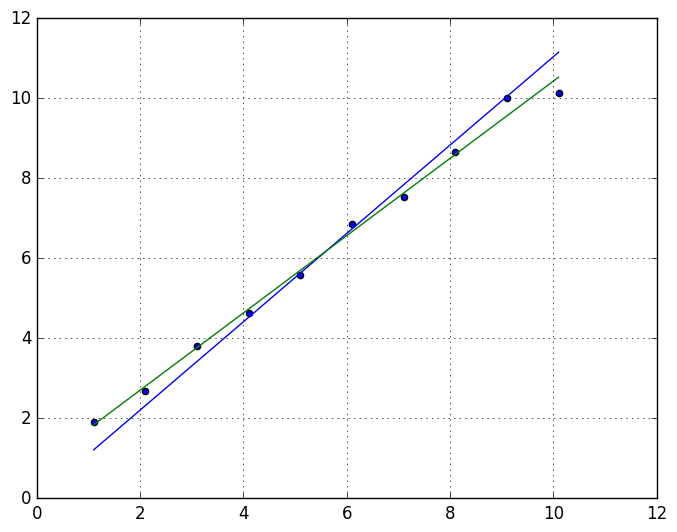

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7ac5966fd0>

In [112]:
using PyPlot

grid("on")

for j in 1:size(points,1)
    xp, yp = points[j, :]
    scatter(xp, yp)
end

y = [getvalue(angCoeff)*points[i, 1] + getvalue(linearCoeff) for i in 1:size(points,1)]
plot(points[:, 1], y)

y = [0.96596 * points[i, 1] + 0.775847 for i in 1:size(points,1)]
plot(points[:, 1], y)

In [79]:
Pkg.add("GLM")

INFO: Cloning cache of Distributions from https://github.com/JuliaStats/Distributions.jl.git
INFO: Cloning cache of GLM from https://github.com/JuliaStats/GLM.jl.git
INFO: Cloning cache of PDMats from https://github.com/JuliaStats/PDMats.jl.git
INFO: Cloning cache of Rmath from https://github.com/JuliaStats/Rmath.jl.git
INFO: Cloning cache of StatsBase from https://github.com/JuliaStats/StatsBase.jl.git
INFO: Cloning cache of StatsFuns from https://github.com/JuliaStats/StatsFuns.jl.git
INFO: Installing Distributions v0.11.1
INFO: Installing GLM v0.6.1
INFO: Installing PDMats v0.5.2
INFO: Installing Rmath v0.1.5
INFO: Installing StatsBase v0.11.1
INFO: Installing StatsFuns v0.3.1
INFO: Building Rmath
INFO: Package database updated


In [82]:
Pkg.add("DataFrames")

INFO: Cloning cache of DataArrays from https://github.com/JuliaStats/DataArrays.jl.git
INFO: Cloning cache of DataFrames from https://github.com/JuliaStats/DataFrames.jl.git
INFO: Cloning cache of GZip from https://github.com/JuliaIO/GZip.jl.git
INFO: Cloning cache of SortingAlgorithms from https://github.com/JuliaLang/SortingAlgorithms.jl.git
INFO: Installing DataArrays v0.3.10
INFO: Installing DataFrames v0.8.5
INFO: Installing GZip v0.2.20
INFO: Installing SortingAlgorithms v0.1.0
INFO: Package database updated


In [110]:
using DataFrames
using GLM
data = DataFrame(X=points[:, 1], Y=points[:, 2])

,X,Y
1,1.1,1.9229738407418053
2,2.1,2.6917057967009814
3,3.1,3.8109868733304517
4,4.1,4.63230432062981
5,5.1,5.586423637920026
6,6.1,6.8693406653816
7,7.1,7.529901584699459
8,8.1,8.664566204277342
9,9.1,10.00388240369874
10,10.1,10.140148154904095


In [111]:
glm(Y ~ X, data, Normal(), IdentityLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Y ~ 1 + X

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)  0.775847  0.163689 4.73978    <1e-5
X             0.96596 0.0260085 37.1401   <1e-99
